# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from helper import *
from datetime import datetime
import time
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import imblearn
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score, f1_score, roc_auc_score
import re
import pickle
from sklearn.externals import joblib
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline

/Users/zhitao.wang/Applications/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### Part 0.1: Load the data set

#### Load Datasets for Customer Segmentation Analysis

**Column 19 (CAMEO_INTL_2015)** and **Column 20 (CJT_GESAMTTYP)** contain mixed types. We can avoid this warning message by converting these two columns as string-type data.

In [2]:
# load the data
azdias = pd.read_csv('arvato_data/Udacity_AZDIAS_052018.csv', sep=';', dtype={19:'str',20:'str'}).drop('Unnamed: 0', axis = 1)
customers = pd.read_csv('arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', dtype={19:'str',20:'str'}).drop('Unnamed: 0', axis = 1)
# Drop the extra column of customers dataset.
customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)

In [3]:
print("Dimension of the demographics data:", azdias.shape)
print("Dimension of the customer data:", customers.shape)

Dimension of the demographics data: (891221, 366)
Dimension of the customer data: (191652, 366)


('X', 'XX') in columns **CAMEO_DEU_2015**, **CAMEO_DEUG_2015**, **CAMEO_INTL_2015** represents missing values, which will be converted into np.nan. 

In [4]:
# check which columns contain 'X' or 'XX' in the population dataset
for col in azdias.columns:
    if ('X' in set(azdias[col].unique())) or ('XX' in set(azdias[col].unique())):
        print(col)

CAMEO_DEU_2015
CAMEO_DEUG_2015
CAMEO_INTL_2015


### Part 0.2: Preprocess the data dictionaries

Let's find the difference between the two data dictionaries provided by the unsupervised learning project and the capstone project. Both dictionaries contains some overlapping features, while some features are not documented anywhere. The first step is to convert the missing codes into NaN values in the dataset, according to the data dictionaries.

In [5]:
# load in the feature summary file provided by previous customer-segmentation project
feat_info_csv = pd.read_csv('arvato_data/AZDIAS_Feature_Summary.csv', delimiter = ';')
# convert missing_or_unknown into lists of NaN: '[-1,0]' -> [-1, 0] and '[-1,XX]' -> [-1, 'XX']
X = 'X'
XX = 'XX'
feat_info_csv['missing_or_unknown'] = feat_info_csv['missing_or_unknown'].apply(lambda x: eval(x))
feat_info_csv.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
# load in feature-value information provided by this capstone project
feat_info_xls = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
# forward fill the row-wise missing values
feat_info_xls[['Type', 'Attribute','Description', 'Meaning']] = \
            feat_info_xls[['Type', 'Attribute','Description','Meaning']].ffill()
# find attributes containing the keywords, such as "unknown", whose row will be flagged as missing 
feat_info_xls['flag'] = feat_info_xls['Meaning'].apply(flag_unknown)
# save features with missing-value, and their corresponding values
feat_nan_xls = feat_info_xls[feat_info_xls['flag'] == True].drop('flag', axis = 1)
feat_nan_xls['Value'] = feat_nan_xls['Value'].astype(str)
feat_nan_xls['Value'] = feat_nan_xls['Value'].apply(lambda x: eval(x))
nan_set = set(feat_nan_xls.Value)
print('Unique values for represeting the missing values are: ', nan_set)
feat_nan_xls.head()

Unique values for represeting the missing values are:  {0, (-1, 0), 10, (-1, 9), -1}


,Type,Attribute,Description,Value,Meaning
0,categorical,AGER_TYP,best-ager typology,-1,unknown
5,ordinal,ALTERSKATEGORIE_GROB,age classification through prename analysis,"(-1, 0)",unknown
11,interval,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,categorical,ANREDE_KZ,gender,"(-1, 0)",unknown
40,ordinal,BALLRAUM,distance to next urban centre,-1,unknown


In [7]:
print('Number of unique features in the data dictionary "AZDIAS_Feature_Summary.csv":',\
      feat_info_csv['attribute'].nunique())
print('Number of unique features in the data dictionary "DIAS Attributes - Values 2017.xlsx":',\
      feat_info_xls['Attribute'].nunique())
print('in which {} unique features are encoded as missing values'.format(feat_nan_xls['Attribute'].nunique()))

Number of unique features in the data dictionary "AZDIAS_Feature_Summary.csv": 85
Number of unique features in the data dictionary "DIAS Attributes - Values 2017.xlsx": 314
in which 289 unique features are encoded as missing values


In [8]:
# check the number of features from the dataset not found in the dictionary
undocumented_features = set(azdias.columns) - set(feat_info_csv['attribute']) - set(feat_info_xls['Attribute'])
print("There are {} features in the dataset not documented anywhere.".format(len(undocumented_features)))
print(undocumented_features)

There are 90 features in the dataset not documented anywhere.
{'D19_BEKLEIDUNG_REST', 'D19_BANKEN_REST', 'D19_KOSMETIK', 'D19_BANKEN_GROSS', 'D19_DROGERIEARTIKEL', 'CJT_TYP_5', 'RT_SCHNAEPPCHEN', 'ALTER_KIND2', 'ALTER_KIND1', 'D19_LETZTER_KAUF_BRANCHE', 'D19_RATGEBER', 'DSL_FLAG', 'D19_WEIN_FEINKOST', 'UMFELD_ALT', 'ALTER_KIND3', 'ANZ_KINDER', 'D19_KINDERARTIKEL', 'STRUKTURTYP', 'D19_VERSI_ONLINE_DATUM', 'D19_VERSICHERUNGEN', 'D19_KONSUMTYP_MAX', 'D19_ENERGIE', 'KONSUMZELLE', 'EINGEFUEGT_AM', 'UNGLEICHENN_FLAG', 'D19_TECHNIK', 'KOMBIALTER', 'KBA13_ANTG1', 'VERDICHTUNGSRAUM', 'D19_VERSI_OFFLINE_DATUM', 'KBA13_CCM_1401_2500', 'D19_GARTEN', 'D19_BILDUNG', 'LNR', 'AKT_DAT_KL', 'KBA13_ANTG3', 'ALTER_KIND4', 'ANZ_STATISTISCHE_HAUSHALTE', 'D19_BANKEN_LOKAL', 'RT_KEIN_ANREIZ', 'UMFELD_JUNG', 'D19_REISEN', 'MOBI_RASTER', 'VHN', 'VK_DISTANZ', 'D19_SCHUHE', 'KBA13_ANTG4', 'D19_TELKO_REST', 'D19_SAMMELARTIKEL', 'KBA13_BAUMAX', 'CJT_TYP_2', 'D19_VERSI_ONLINE_QUOTE_12', 'GEMEINDETYP', 'EINGEZOGENAM_

#### Note: some features in the data dictionary are not found in the dataset.

In [9]:
# check the number of features from the dictionary not found in the dataset
not_found_features =  set(feat_info_xls['Attribute']) - set(azdias.columns)
print("There are {} features in the dictionary not found in the dataset".format(len(not_found_features)))
print(not_found_features)

There are 42 features in the dictionary not found in the dataset
{'D19_VERSICHERUNGEN_RZ', 'D19_ENERGIE_RZ', 'D19_REISEN_RZ', 'D19_GARTEN_RZ', 'GEOSCORE_KLS7', 'D19_HANDWERK_RZ', 'D19_NAHRUNGSERGAENZUNG_RZ', 'WACHSTUMSGEBIET_NB', 'BIP_FLAG', 'D19_BEKLEIDUNG_REST_RZ', 'D19_BILDUNG_RZ', 'D19_SAMMELARTIKEL_RZ', 'D19_VOLLSORTIMENT_RZ', 'D19_SONSTIGE_RZ', 'D19_RATGEBER_RZ', 'D19_LOTTO_RZ', 'D19_BANKEN_LOKAL_RZ', 'D19_KINDERARTIKEL_RZ', 'SOHO_FLAG', 'D19_KOSMETIK_RZ', 'D19_TELKO_MOBILE_RZ', 'KBA13_CCM_1400_2500', 'D19_WEIN_FEINKOST_RZ', 'CAMEO_DEUINTL_2015', 'D19_FREIZEIT_RZ', 'D19_BANKEN_DIREKT_RZ', 'D19_DIGIT_SERV_RZ', 'D19_TELKO_REST_RZ', 'D19_BUCH_RZ', 'D19_BEKLEIDUNG_GEH_RZ', 'D19_LEBENSMITTEL_RZ', 'D19_TIERARTIKEL_RZ', 'D19_KK_KUNDENTYP', 'D19_TECHNIK_RZ', 'D19_SCHUHE_RZ', 'D19_DROGERIEARTIKEL_RZ', 'D19_VERSAND_REST_RZ', 'D19_BANKEN_GROSS_RZ', 'D19_HAUS_DEKO_RZ', 'HAUSHALTSSTRUKTUR', 'D19_BIO_OEKO_RZ', 'D19_BANKEN_REST_RZ'}


#### Discussion:

These non-overlaping features are mostly belonged to transaction-related features, with prefix "D19", and postfix "_RZ". Let's remove the postfix of the feature name in the dictionary, and check how many unmatched features remains.

In [10]:
# rename D19_*_RZ to D19_* in the dictionary
feat_info_xls['Attribute'] = feat_info_xls['Attribute'].apply(lambda x: re.sub('_RZ', '', x) if 'D19' in x else x)
feat_nan_xls['Attribute'] = feat_nan_xls['Attribute'].apply(lambda x: re.sub('_RZ', '', x) if 'D19' in x else x)

In [11]:
# check again for the number of features from the dataset not found in the dictionary
undocumented_features = set(azdias.columns) - set(feat_info_csv['attribute']) - set(feat_info_xls['Attribute'])
print("After remapping, there are {} features in the dataset not documented anywhere.".format(len(undocumented_features)))
print(undocumented_features)

After remapping, there are 57 features in the dataset not documented anywhere.
{'CJT_TYP_2', 'LNR', 'AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'D19_VERSI_ONLINE_QUOTE_12', 'KBA13_ANTG3', 'ALTER_KIND4', 'GEMEINDETYP', 'ANZ_STATISTISCHE_HAUSHALTE', 'CJT_TYP_5', 'RT_SCHNAEPPCHEN', 'EINGEZOGENAM_HH_JAHR', 'VK_ZG11', 'ALTER_KIND2', 'D19_VERSI_DATUM', 'CJT_TYP_1', 'KBA13_KMH_210', 'ALTER_KIND1', 'RT_KEIN_ANREIZ', 'D19_SOZIALES', 'UMFELD_JUNG', 'D19_LETZTER_KAUF_BRANCHE', 'CJT_TYP_3', 'DSL_FLAG', 'KBA13_HHZ', 'UMFELD_ALT', 'RT_UEBERGROESSE', 'ALTER_KIND3', 'ANZ_KINDER', 'CJT_TYP_6', 'MOBI_RASTER', 'VK_DHT4A', 'FIRMENDICHTE', 'STRUKTURTYP', 'D19_VERSI_ONLINE_DATUM', 'VHN', 'D19_KONSUMTYP_MAX', 'VK_DISTANZ', 'KBA13_ANTG4', 'KONSUMZELLE', 'KBA13_GBZ', 'CJT_KATALOGNUTZER', 'CJT_TYP_4', 'EXTSEL992', 'EINGEFUEGT_AM', 'UNGLEICHENN_FLAG', 'D19_BUCH_CD', 'KOMBIALTER', 'KBA13_ANTG1', 'VERDICHTUNGSRAUM', 'HH_DELTA_FLAG', 'D19_VERSI_OFFLINE_DATUM', 'KBA13_CCM_1401_2500', 'KBA13_ANTG2', 'VHA', 'D19_TELKO_ONLIN

In [12]:
# check again for the number of features from the dictionary not found in the dataset
not_found_features =  set(feat_info_xls['Attribute']) - set(azdias.columns)
print("After remapping, there are still {} features in the dictionary not found in the dataset".format(len(not_found_features)))
print(not_found_features)

After remapping, there are still 9 features in the dictionary not found in the dataset
{'KBA13_CCM_1400_2500', 'CAMEO_DEUINTL_2015', 'GEOSCORE_KLS7', 'HAUSHALTSSTRUKTUR', 'WACHSTUMSGEBIET_NB', 'SOHO_FLAG', 'BIP_FLAG', 'D19_BUCH', 'D19_KK_KUNDENTYP'}


In [13]:
# merge feature missing codes from two dictionaries
feat_nan_code = feat_info_csv[['attribute', 'missing_or_unknown']].rename(columns={'attribute': 'Attribute', 'missing_or_unknown': 'Value'})
feat_nan_code = pd.concat([feat_nan_code, feat_nan_xls[['Attribute', 'Value']]]).drop_duplicates('Attribute').reset_index(drop=True)

In [14]:
# merge feature type from two dictionaries
feat_cat = feat_info_csv[['attribute', 'type']].rename(columns={'attribute': 'Attribute', 'type': 'Type'})
feat_cat = pd.concat([feat_cat, feat_info_xls[['Attribute', 'Type']]]).drop_duplicates('Attribute').reset_index(drop=True)

In [15]:
# export to csv file
feat_nan_code.to_csv('arvato_data/feature_missing_code.csv', sep = '\t')
feat_cat.to_csv('arvato_data/feature_type.csv', sep = '\t')

### Part 0.3: Assess Missing Data

In [16]:
feat_nan_code = pd.read_csv('arvato_data/feature_missing_code.csv', sep = '\t').drop('Unnamed: 0', axis = 1)
feat_cat = pd.read_csv('arvato_data/feature_type.csv', sep = '\t').drop('Unnamed: 0', axis = 1)

In [17]:
# convert missing_or_unknown into lists of NaN: '[-1,0]' -> [-1, 0] and '[-1,XX]' -> [-1, 'XX']
X = 'X'
XX = 'XX'
feat_nan_code['Value'] = feat_nan_code['Value'].apply(lambda x: eval(x))

In [18]:
# convert NaN codes to np.nan
convert_nan(azdias, feat_nan_code)

In [19]:
# Convert row input strings to float
azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(float)

In [20]:
# sanity check if there still are 'X' or 'XX' in the population dataset
for col in azdias.columns:
    if ('X' in set(azdias[col].unique())) or ('XX' in set(azdias[col].unique())):
        print(col)

The following step of analysis will be similar to the unsupervised learning project.

#### Step 0.3.1: Assess Missing Data in Each Column

In [21]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

ls = []
# calculate percentage of NaN in each data column
for i, column in enumerate(azdias.columns):
    count = azdias[column].isnull().sum(axis=0)
    percent = count/azdias.shape[0]
    ls.append([column, count, percent*100])
# store into summary table, sorted by percentage
azdias_summary = pd.DataFrame.from_records(ls, columns = ['Feature', 'NaN Count', 'NaN Occupancy Rate'])
azdias_summary = azdias_summary.sort_values('NaN Occupancy Rate',axis=0,ascending = False)

In [22]:
# explore top 10 features 
azdias_summary.head(10)

,Feature,NaN Count,NaN Occupancy Rate
7,ALTER_KIND4,890016,99.864792
349,TITEL_KZ,889061,99.757636
6,ALTER_KIND3,885051,99.307691
76,D19_TELKO_ONLINE_DATUM,883018,99.079577
33,D19_BANKEN_LOKAL,874745,98.151300
34,D19_BANKEN_OFFLINE_DATUM,871535,97.791120
5,ALTER_KIND2,861722,96.690047
71,D19_TELKO_ANZ_12,857990,96.271295
43,D19_DIGIT_SERV,857661,96.234380
41,D19_BIO_OEKO,854074,95.831898


In [23]:
azdias_summary[azdias_summary.Feature == 'D19_SOZIALES']

,Feature,NaN Count,NaN Occupancy Rate
69,D19_SOZIALES,257113,28.849522


Looks like many features, for instance, the transaction-history-related features (prefix "D19") can be dropped due to high NaN ratio.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a0efaea90>]], dtype=object)

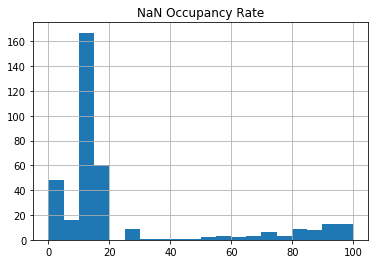

In [24]:
# visualize the distribution of missing value counts to find these columns
azdias_summary.hist(column='NaN Occupancy Rate', bins = 20)

In [25]:
# Identify outliers (say above 30% is considered as outliers) from the histogram and document these features
col_thres = 30
feature_to_drop = azdias_summary[azdias_summary['NaN Occupancy Rate'] > col_thres]
print("Number of feature to be dropped out: ", feature_to_drop.shape[0])
feature_to_drop.to_csv('arvato_data/dropped_feature.csv')
display(feature_to_drop)

Number of feature to be dropped out:  66


,Feature,NaN Count,NaN Occupancy Rate
7,ALTER_KIND4,890016,99.864792
349,TITEL_KZ,889061,99.757636
6,ALTER_KIND3,885051,99.307691
76,D19_TELKO_ONLINE_DATUM,883018,99.079577
33,D19_BANKEN_LOKAL,874745,98.151300
34,D19_BANKEN_OFFLINE_DATUM,871535,97.791120
5,ALTER_KIND2,861722,96.690047
71,D19_TELKO_ANZ_12,857990,96.271295
43,D19_DIGIT_SERV,857661,96.234380
41,D19_BIO_OEKO,854074,95.831898


#### Step 0.3.2: Assess Missing Data in Each Row

In [26]:
# Investigate patterns in the amount of missing data in each column.
azdias_drop_NaN = azdias.drop(feature_to_drop.Feature, axis=1)
azdias_subset = azdias_drop_NaN.isnull().astype(int) 
azdias_subset = azdias_subset[azdias_subset.sum(axis = 1) > col_thres]

In [27]:
# How much data is missing in each row of the dataset?
ncol = azdias_drop_NaN.shape[1]
azdias_drop_NaN['NaN Count'] = azdias_drop_NaN.isnull().sum(axis=1)
azdias_drop_NaN['NaN Occupancy Rate'] = azdias_drop_NaN['NaN Count'].apply(lambda x: x/ncol*100)
azdias_drop_NaN['label'] = azdias_drop_NaN['NaN Occupancy Rate'].apply(lambda x: '%NaN Below '+str(int(col_thres)) \
        if x <= col_thres else '%NaN Above '+str(int(col_thres)))
azdias_drop_NaN[['NaN Count', 'NaN Occupancy Rate', 'label']].sort_values( \
        'NaN Occupancy Rate',axis=0,ascending = False).head()

,NaN Count,NaN Occupancy Rate,label
826869,253,84.333333,%NaN Above 30
537799,253,84.333333,%NaN Above 30
721052,252,84.000000,%NaN Above 30
642352,252,84.000000,%NaN Above 30
489878,252,84.000000,%NaN Above 30


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a0f00db70>]], dtype=object)

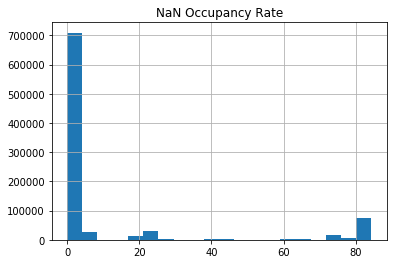

In [28]:
# plot the histogram
azdias_drop_NaN.hist(column='NaN Occupancy Rate', bins = 20)

In [29]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
row_thres = 30
idx = azdias_drop_NaN['NaN Occupancy Rate'] > row_thres
outlier_CNT = azdias_drop_NaN[idx].shape[0]
outlier_PCT = outlier_CNT/azdias_drop_NaN.shape[0]*100
print('The total count of data above NaNs {}% threshold is {}, which consist of {}% of data set'.format(row_thres, outlier_CNT, outlier_PCT))

The total count of data above NaNs 30% threshold is 105903, which consist of 11.88291119711048% of data set


In [30]:
# Store the row data with the number of missing values below the threshold. 
# Keep in mind that the last column 'label' should be dropped out.
# We will use this data subset in the following analysis.
azdias_small_NaN = azdias_drop_NaN[~idx].drop(['NaN Count', 'NaN Occupancy Rate', 'label'], axis = 1).reset_index(drop=True)
print('The number of rows and columns in the new dataset are:', azdias_small_NaN.shape)
display(azdias_small_NaN.head())

The number of rows and columns in the new dataset are: (785318, 300)


,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910220,9.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1.0
1,910225,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3.0
2,910226,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4.0
3,910241,1.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3.0
4,910244,1.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1.0


In [31]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Explore features with the least NaN occupancy percentage. We can pick 5 of them to make count plots.
azdias_summary.sort_values('NaN Occupancy Rate',axis=0,ascending = True).head(10)

,Feature,NaN Count,NaN Occupancy Rate
0,LNR,0,0.0
335,SEMIO_KAEM,0,0.0
107,FINANZTYP,0,0.0
364,ANREDE_KZ,0,0.0
363,ZABEOTYP,0,0.0
42,D19_BUCH_CD,0,0.0
58,D19_KONSUMTYP_MAX,0,0.0
89,D19_VERSI_DATUM,0,0.0
90,D19_VERSI_OFFLINE_DATUM,0,0.0
91,D19_VERSI_ONLINE_DATUM,0,0.0


In [32]:
# seleted features with no missing value or low NaN occupancy rate
selected_features = ['ZABEOTYP', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_SPARER', 'ANREDE_KZ', 'SEMIO_KAEM', \
     'ALTERSKATEGORIE_GROB', 'ONLINE_AFFINITAET', 'SEMIO_MAT', 'SEMIO_REL',\
    'CAMEO_INTL_2015', 'ORTSGR_KLS9', 'NATIONALITAET_KZ']

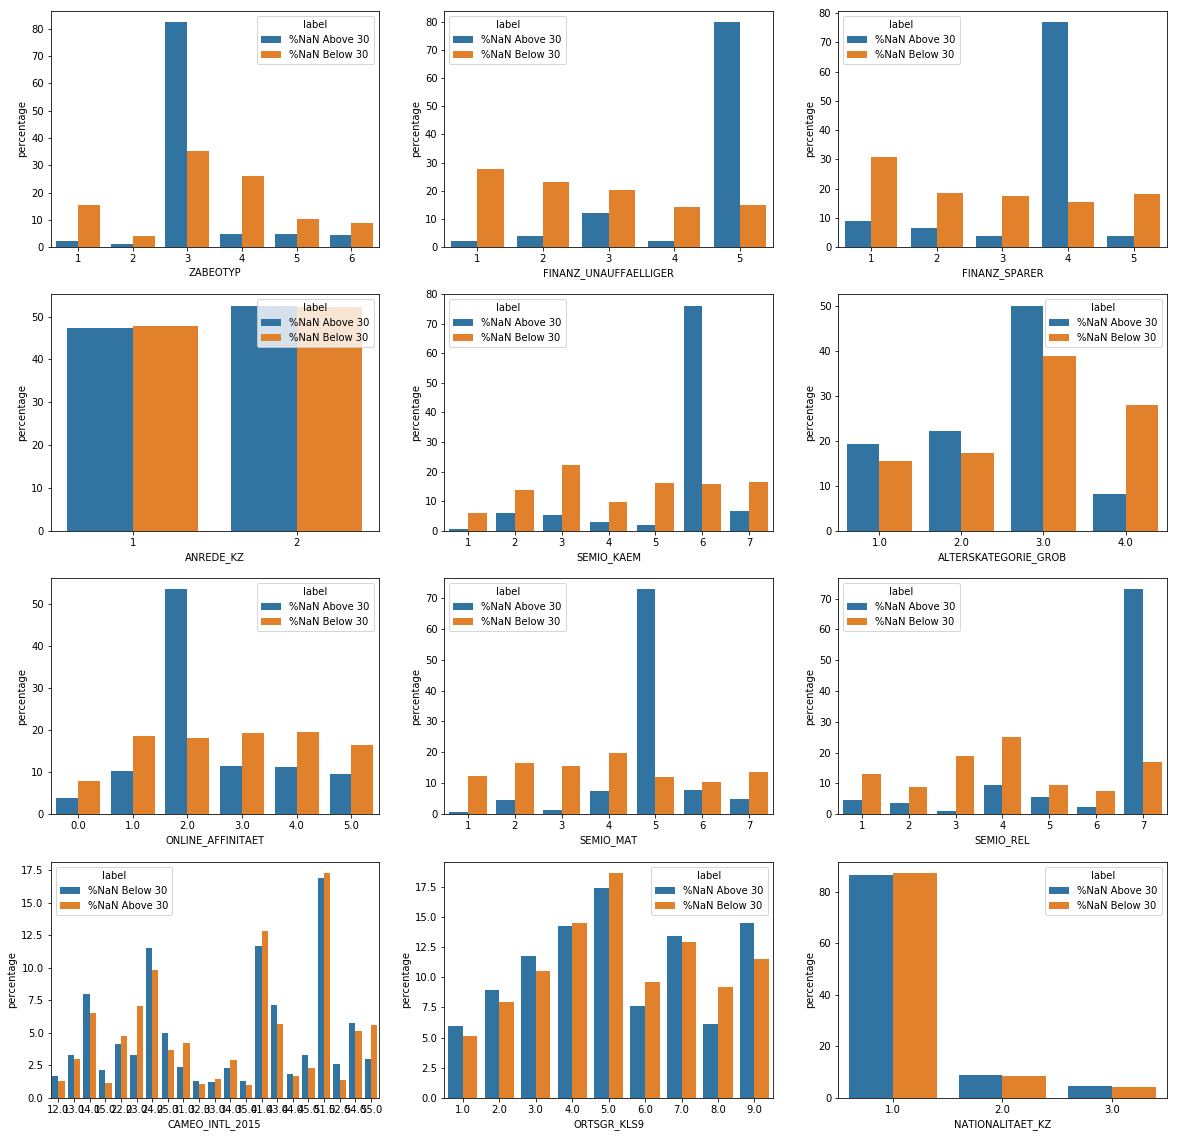

In [33]:
# plot the distribution of data below and above the threshold for each selected feature
count_plot(azdias_drop_NaN, selected_features, 'label', normalized = True)

#### Discussion

The histogram distribution (the first plot in Step 0.3.2) shows that most data peaks around 0% missing values, and decays quickly. Only a few outliers lies in the 30% buckets and above. Therefore, we can use 30% as a threshold to separate these outliers from the normal data.

Although these outliers only consist of 10% of the total population, we should pay attention because their distributions in some features are quite different from the majority group (below the threshold), as shown by the count plot in the second plot above. In some features, such as ANREDE_KZ (associated with the gender), NATIONALITAET_KZ (associated with the originality), the distribution of the two groups are very similar to each other. However, many features show quite different distribution: the outlier spike in "7" buckets in SEMIO_REL (associated with personality), and "5" in FINANZ_UNAUFFAELLIGER (associated with financial typology). Therefore, the statistics suggest treat these two populations are quite distinct from each other. In the following analysis, we will flag the data with row missing values above the threshold, and only focus on studying the majority group with few or no missing values.

### Part 0.4: Engineer Features

In [34]:
# How many features are there of each data type?
display('Number of features type according to data dictionary:', feat_cat[['Attribute', 'Type']].groupby(['Type']).count())

'Number of features type according to data dictionary:'

,Attribute
Type,
categorical,61
interval,4
mixed,12
numeric,7
ordinal,234


#### Step 0.4.1: Re-Encode Categorical Features

In [35]:
# select all categorical features
categorical_feat = feat_cat[feat_cat['Type'] == 'categorical']

In [36]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# full categorical features from the data dictionary
categorical_feat_list = categorical_feat['Attribute'].tolist()
# list of categorical features that we have dropped in previous step
categorical_feat_to_drop = feature_to_drop['Feature'].values.tolist()
# only keep the selected features for re-encoding
categorical_dummy = [x for x in categorical_feat_list \
                     if (x not in categorical_feat_to_drop) and (x not in not_found_features)]
print("List of categorical variables to be re-encoded: \n", categorical_dummy)

List of categorical variables to be re-encoded: 
 ['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'D19_KONSUMTYP', 'KBA05_MAXHERST', 'KBA05_MAXSEG']


In [37]:
# Re-encode categorical variable(s) to be kept in the analysis.
'''
    Step 1: impute the most frequent value for the missing data in each column
'''

# list of columns with missing values:
nan_cols = azdias_small_NaN.columns[azdias_small_NaN.isnull().any()].tolist()

for col in nan_cols:
    print("replacing the NaN with most frequent value in column: ", col)
    impute_na(azdias_small_NaN, col)

replacing the NaN with most frequent value in column:  ALTERSKATEGORIE_FEIN
replacing the NaN with most frequent value in column:  ANZ_HAUSHALTE_AKTIV
replacing the NaN with most frequent value in column:  ANZ_HH_TITEL
replacing the NaN with most frequent value in column:  ARBEIT
replacing the NaN with most frequent value in column:  BALLRAUM
replacing the NaN with most frequent value in column:  CAMEO_DEU_2015
replacing the NaN with most frequent value in column:  CAMEO_DEUG_2015
replacing the NaN with most frequent value in column:  CAMEO_INTL_2015
replacing the NaN with most frequent value in column:  CJT_GESAMTTYP
replacing the NaN with most frequent value in column:  CJT_KATALOGNUTZER
replacing the NaN with most frequent value in column:  CJT_TYP_1
replacing the NaN with most frequent value in column:  CJT_TYP_2
replacing the NaN with most frequent value in column:  CJT_TYP_3
replacing the NaN with most frequent value in column:  CJT_TYP_4
replacing the NaN with most frequent valu

replacing the NaN with most frequent value in column:  VERDICHTUNGSRAUM
replacing the NaN with most frequent value in column:  VERS_TYP
replacing the NaN with most frequent value in column:  VHN
replacing the NaN with most frequent value in column:  VK_DHT4A
replacing the NaN with most frequent value in column:  VK_DISTANZ
replacing the NaN with most frequent value in column:  VK_ZG11
replacing the NaN with most frequent value in column:  W_KEIT_KIND_HH
replacing the NaN with most frequent value in column:  ALTERSKATEGORIE_GROB


In [38]:
# sanity check:
col_sc = 'NATIONALITAET_KZ'
print('Are there any np.nan in the column "{}"? {}'.format(col_sc, azdias_small_NaN[col_sc].isnull().any()))

Are there any np.nan in the column "NATIONALITAET_KZ"? False


In [39]:
''' Step 2: convert selected categorical variables from above into dummy variable representation, 
        and replace original column names by using their prefix + categorical value
'''
azdias_CAT_OHE = pd.get_dummies(azdias_small_NaN, prefix = categorical_dummy, columns = categorical_dummy)

In [40]:
azdias_CAT_OHE.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,D19_KONSUMTYP_9.0,KBA05_MAXHERST_1.0,KBA05_MAXHERST_2.0,KBA05_MAXHERST_3.0,KBA05_MAXHERST_4.0,KBA05_MAXHERST_5.0,KBA05_MAXSEG_1.0,KBA05_MAXSEG_2.0,KBA05_MAXSEG_3.0,KBA05_MAXSEG_4.0
0,910220,9.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,1,0,1,0,0,0,0,0,0,1
1,910225,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,1,0,0,0,0,1,1,0,0,0
2,910226,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,1,0,0,1,0,0,0,1,0,0
3,910241,1.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,0,0,0,1,0,0,1,0,0,0
4,910244,1.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,0,0,1,0,0,0,0,1,0,0


#### Discussion

By exploring all categorical variables and values from the data dictionary, I found "OST_WEST_KZ" is the only one binary categorical variable with non-numeric values, and the rest are multi-categorical variables. Rather than dropping multi-categorical variables which could potentially losses valuable information, I would prefer to keep and create all of these as dummy variables.

Below is the complete list of categorical feature name (that I re-encoded as dummy varialbes), followed by the corresponding possible values from the data dictionary, where the "dropped" in the parenthesis indicates they have been removed due to high NaN occupancy rates in preliminary analysis above.

1. Binary Non-numeric Categoricals
    * OST_WEST_KZ O W

2. Multi-level Categoricals
    * AGER_TYP, values: 1~3 (dropped)
    * ANREDE_KZ, values: 1, 2
    * CJT_GESAMTTYP, values: 1~6
    * FINANZTYP, values: 1~6
    * GFK_URLAUBERTYP, values: 1~12
    * GREEN_AVANTGARDE, values: 0, 1
    * LP_FAMILIE_FEIN, values: 1~11
    * LP_FAMILIE_GROB, values: 1~5
    * LP_STATUS_FEIN, values: 1~10
    * LP_STATUS_GROB, values: 1~5
    * NATIONALITAET_KZ, values: 1~3
    * SHOPPER_TYP, values: 0~3
    * SOHO_KZ, values: 0, 1
    * TITEL_KZ, values: 1~5 (dropped)
    * VERS_TYP, values: 1, 2
    * ZABEOTYP, values: 1~9
    * KK_KUNDENTYP, values: 1~6 (dropped)
    * GEBAEUDETYP, values: 1~8
    * CAMEO_DEUG_2015, values: 1~9
    * CAMEO_DEU_2015, values: 1A, 1B, etc.
    * D19_KONSUMTYP, values: 1~9
    * KBA05_MAXHERST, values: 1~5
    * KBA05_MAXSEG, values: 1~4

#### Step 0.4.2: Engineer Mixed-Type Features

In [41]:
# explore all mixed type features
mixed_feat = feat_cat[feat_cat['Type'] == 'mixed']
display(mixed_feat)

,Attribute,Type
15,LP_LEBENSPHASE_FEIN,mixed
16,LP_LEBENSPHASE_GROB,mixed
22,PRAEGENDE_JUGENDJAHRE,mixed
56,WOHNLAGE,mixed
59,CAMEO_INTL_2015,mixed
64,KBA05_BAUMAX,mixed
79,PLZ8_BAUMAX,mixed
86,CAMEO_DEUINTL_2015,mixed
149,HAUSHALTSSTRUKTUR,mixed
167,KBA05_HERSTTEMP,mixed


The list above shows all mixed-type features in the data dictionary, which is similar to previous unsupervised-learning project, except **HAUSHALTSSTRUKTUR**, **WACHSTUMSGEBIET_NB**, **KBA05_HERSTTEMP** and **KBA05_MODTEMP**. Recall that **HAUSHALTSSTRUKTUR** and **WACHSTUMSGEBIET_NB** are non-existing features in the dataset. Two additional categorical variables should be re-engineer here: **KBA05_HERSTTEMP** and **KBA05_MODTEMP**.

In [42]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_CAT_OHE['DECADE'] = azdias_CAT_OHE['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: feature_decade(x))
azdias_CAT_OHE['MOVEMENT'] = azdias_CAT_OHE['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: feature_movement(x))     

In [43]:
# sanity check on PRAEGENDE_JUGENDJAHRE mapping
azdias_CAT_OHE[['PRAEGENDE_JUGENDJAHRE', 'DECADE', 'MOVEMENT']].head()

,PRAEGENDE_JUGENDJAHRE,DECADE,MOVEMENT
0,14.0,6,0
1,15.0,6,1
2,8.0,4,0
3,8.0,4,0
4,3.0,2,0


In [44]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_CAT_OHE['WEALTH'] = azdias_CAT_OHE['CAMEO_INTL_2015'].astype(float).apply(lambda x: np.floor(x / 10))
azdias_CAT_OHE['LIFE_STAGE'] = azdias_CAT_OHE['CAMEO_INTL_2015'].astype(float).apply(lambda x: (x % 10)) 

In [45]:
# sanity check on CAMEO_INTL_2015 mapping
azdias_CAT_OHE[['CAMEO_INTL_2015', 'WEALTH', 'LIFE_STAGE']].head()

,CAMEO_INTL_2015,WEALTH,LIFE_STAGE
0,51.0,5.0,1.0
1,24.0,2.0,4.0
2,12.0,1.0,2.0
3,43.0,4.0,3.0
4,54.0,5.0,4.0


In [46]:
# Investigate "WOHNLAGE" and engineer two new variables.
azdias_CAT_OHE['NEIGHBORHOOD'] = azdias_CAT_OHE['WOHNLAGE'].astype(float).apply(lambda x: feature_neighborhood(x))
azdias_CAT_OHE['RURAL_FLAG'] = azdias_CAT_OHE['WOHNLAGE'].astype(float).apply(lambda x: feature_rural(x))
impute_na(azdias_CAT_OHE, 'NEIGHBORHOOD')
impute_na(azdias_CAT_OHE, 'RURAL_FLAG')

In [47]:
# Investigate "PLZ8_BAUMAX" and engineer two new variables.
azdias_CAT_OHE['PLZ8_HOMES'] = azdias_CAT_OHE['PLZ8_BAUMAX'].astype(float).apply(lambda x: feature_homes(x))
azdias_CAT_OHE['PLZ8_BUSINESS'] = azdias_CAT_OHE['PLZ8_BAUMAX'].astype(float).apply(lambda x: feature_business(x))
impute_na(azdias_CAT_OHE, 'PLZ8_HOMES')
impute_na(azdias_CAT_OHE, 'PLZ8_BUSINESS')

In [48]:
# Investigate KBA05_HERSTTEMP, and engineer one ordinal variable, and one binary categorical variable respectively.
azdias_CAT_OHE['KBA05_HERSTTEMP_NEIGHBORHOOD_DEV'] = azdias_CAT_OHE['KBA05_HERSTTEMP'].astype(float).apply(lambda x: feature_neighborhood_development(x))
azdias_CAT_OHE['KBA05_HERSTTEMP_NB_FLG'] = azdias_CAT_OHE['KBA05_HERSTTEMP'].astype(float).apply(lambda x: feature_new_building_flag(x))
impute_na(azdias_CAT_OHE, 'KBA05_HERSTTEMP_NEIGHBORHOOD_DEV')
impute_na(azdias_CAT_OHE, 'KBA05_HERSTTEMP_NB_FLG')

In [49]:
# Investigate KBA05_HERSTTEMP, and engineer one ordinal variable, and one binary categorical variable respectively.
azdias_CAT_OHE['KBA05_MODTEMP_NEIGHBORHOOD_DEV'] = azdias_CAT_OHE['KBA05_MODTEMP'].astype(float).apply(lambda x: feature_neighborhood_development(x))
azdias_CAT_OHE['KBA05_MODTEMP_NB_FLG'] = azdias_CAT_OHE['KBA05_MODTEMP'].astype(float).apply(lambda x: feature_new_building_flag(x))
impute_na(azdias_CAT_OHE, 'KBA05_MODTEMP_NEIGHBORHOOD_DEV')
impute_na(azdias_CAT_OHE, 'KBA05_MODTEMP_NB_FLG')

#### Discussion

For <strong>PRAEGENDE_JUGENDJAHRE</strong>, I separated into two new features: an interval-type variable for "DECADE" (mapping relation: 40s --> 1, 50s --> 2, 60s --> 3, 70s --> 4, 80s --> 5, 90s --> 6, and NaN --> NaN) and and a binary variable for "MOVEMENT" (mapping relation: Mainstream --> 0, Avantgarde --> 1, and NaN --> NaN). 

For <strong>CAMEO_INTL_2015</strong>, I broke up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables: WEALTH (lower score indicates more wealthy) and LIFE_STAGE (lower score indicates younger age).

For <strong>WOHNLAGE</strong>, I created two new features: <strong>NEIGHBORHOOD</strong> and <strong>RURAL_FLAG</strong>. The former feature indicate the neibourhood quality, scales from 1-5, whereas 7-8 are treated as missing values, which will be later imputed. The latter feature indicate whether is in rural area, with 1-5 corresponding to not rural, and 7-8 to rural.

For <strong>PLZ8_BAUMAX</strong>, it is replaced by ordinal variable <strong>PLZ8_HOMES</strong> to indicate building type within the PLZ8 region, and <strong>PLZ8_BUSINESS</strong> as a binary variable flag business and non-business type.

For both <strong>KBA05_HERSTTEMP</strong> and  <strong>KBA05_MODTEMP</strong>, they are replaced by ordinal variable to indicate neighbourbood development status within the KBA05 region, and a binary variable to flag new/old building type.


Lastly, I decided to drop the following features <strong>LP_LEBENSPHASE_FEIN</strong>, <strong>LP_LEBENSPHASE_GROB</strong>, since they are high-dimensional features made up from the duplicated features of <strong>LP_FAMILIE_FEIN</strong>, <strong>LP_FAMILIE_GROB</strong>, <strong>LP_STATUS_GROB</strong>.

#### Step 0.4.3: Engineer Other Object-Type Features

In [50]:
# show all non-numeric data columns
azdias_CAT_OHE.columns[azdias_CAT_OHE.dtypes == object]

Index(['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM'], dtype='object')

In [51]:
# engineer year variable from EINGEFUEGT_AM
azdias_CAT_OHE['EINGEFUEGT_AM_YEAR'] = azdias_CAT_OHE['EINGEFUEGT_AM'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).year)
azdias_CAT_OHE['EINGEFUEGT_AM_MONTH'] = azdias_CAT_OHE['EINGEFUEGT_AM'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).month)
azdias_CAT_OHE[['EINGEFUEGT_AM_YEAR', 'EINGEFUEGT_AM_MONTH']].head()

,EINGEFUEGT_AM_YEAR,EINGEFUEGT_AM_MONTH
0,1992,2
1,1992,2
2,1997,4
3,1992,2
4,1992,2


In [52]:
# create dummy variables for D19_LETZTER_KAUF_BRANCHE
dummies = pd.get_dummies(azdias_CAT_OHE['D19_LETZTER_KAUF_BRANCHE'], prefix = 'D19_LETZTER_KAUF_BRANCHE')
azdias_CAT_OHE = pd.concat([azdias_CAT_OHE, dummies], axis = 1)

In [53]:
# create dummy variables for D19_KONSUMTYP_MAX
dummies = pd.get_dummies(azdias_CAT_OHE['D19_KONSUMTYP_MAX'], prefix = 'D19_KONSUMTYP_MAX')
azdias_CAT_OHE = pd.concat([azdias_CAT_OHE, dummies], axis = 1)

In [54]:
# don't forget to drop original columns
azdias_processed = azdias_CAT_OHE.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', \
                                        'WOHNLAGE', 'PLZ8_BAUMAX', 'LP_LEBENSPHASE_FEIN', \
                                        'LP_LEBENSPHASE_GROB', 'KBA05_HERSTTEMP', 'KBA05_MODTEMP', \
                                        'EINGEFUEGT_AM', 'D19_LETZTER_KAUF_BRANCHE', 'D19_KONSUMTYP_MAX'], axis = 1)
print("The new dataset dimension is: ", azdias_processed.shape)

The new dataset dimension is:  (785318, 477)


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [2]:
# you can skip running cells in part 0
# load the demongraphic dataset
azdias = pd.read_csv('arvato_data/Udacity_AZDIAS_052018.csv', sep=';', dtype={19:'str',20:'str'}).drop('Unnamed: 0', axis = 1)
# load customer dataset
customers = pd.read_csv('arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', dtype={19:'str',20:'str'}).drop('Unnamed: 0', axis = 1)
# Drop the extra column of customers dataset.
customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)
# load missing codes obtained from the dictionary 
feat_nan_code = pd.read_csv('arvato_data/feature_missing_code.csv', sep = '\t').drop('Unnamed: 0', axis = 1)
# load feature type obtained from the dictionary
feat_cat = pd.read_csv('arvato_data/feature_type.csv', sep = '\t').drop('Unnamed: 0', axis = 1)
# load feature to be dropped obtained from Step 0.3.1
feature_to_drop = pd.read_csv('arvato_data/dropped_feature.csv')

In [3]:
mailout_train = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', dtype={19:'str',20:'str'}).drop('Unnamed: 0', axis = 1)
X_train_ID = mailout_train[['LNR']]
X_train = mailout_train.drop(['RESPONSE'], axis = 1)
y_train = mailout_train[['RESPONSE']]

mailout_test = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';', dtype={19:'str',20:'str'}).drop('Unnamed: 0', axis = 1)
X_test_ID = mailout_test[['LNR']]
X_test = mailout_test

print("Number of columns: general demongraphics: {}, customer: {}, trainset: {}"\
      .format(azdias.shape[1], customers.shape[1], X_train.shape[1], X_test.shape[1]))

Number of columns: general demongraphics: 366, customer: 366, trainset: 366


In [4]:
# convert missing_or_unknown into lists of NaN: '[-1,0]' -> [-1, 0] and '[-1,XX]' -> [-1, 'XX']
X = 'X'
XX = 'XX'
feat_nan_code['Value'] = feat_nan_code['Value'].apply(lambda x: eval(x))

In [5]:
azdias_processed, azdias_unprocessed = clean_data(azdias, feat_nan_code, feat_cat, feature_to_drop = feature_to_drop, row_thres = 30)
customers_processed, customers_unprocessed = clean_data(customers, feat_nan_code, feat_cat, feature_to_drop = feature_to_drop, row_thres = 30)
X_train_processed, X_train_unprocessed = clean_data(X_train, feat_nan_code, feat_cat, feature_to_drop = feature_to_drop, row_thres = 30)
X_test_processed, X_test_unprocessed = clean_data(X_test, feat_nan_code, feat_cat, feature_to_drop = feature_to_drop, row_thres = 30)


 Step 1: drop the following features with high NaN occupancy rate above None%: 
 ['ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'D19_TELKO_ONLINE_DATUM', 'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM', 'ALTER_KIND2', 'D19_TELKO_ANZ_12', 'D19_DIGIT_SERV', 'D19_BIO_OEKO', 'D19_TIERARTIKEL', 'D19_NAHRUNGSERGAENZUNG', 'D19_GARTEN', 'D19_LEBENSMITTEL', 'D19_WEIN_FEINKOST', 'D19_BANKEN_ANZ_12', 'D19_ENERGIE', 'D19_TELKO_ANZ_24', 'D19_BANKEN_REST', 'D19_VERSI_ANZ_12', 'D19_TELKO_OFFLINE_DATUM', 'D19_BILDUNG', 'ALTER_KIND1', 'D19_BEKLEIDUNG_GEH', 'D19_RATGEBER', 'D19_SAMMELARTIKEL', 'D19_BANKEN_ANZ_24', 'D19_FREIZEIT', 'D19_BANKEN_GROSS', 'D19_VERSI_ANZ_24', 'D19_SCHUHE', 'D19_HANDWERK', 'D19_TELKO_REST', 'D19_DROGERIEARTIKEL', 'D19_KINDERARTIKEL', 'D19_LOTTO', 'D19_KOSMETIK', 'D19_REISEN', 'D19_VERSAND_REST', 'D19_BANKEN_DIREKT', 'D19_BANKEN_ONLINE_DATUM', 'D19_TELKO_MOBILE', 'D19_HAUS_DEKO', 'D19_BEKLEIDUNG_REST', 'AGER_TYP', 'D19_BANKEN_DATUM', 'D19_TELKO_DATUM', 'D19_VERSICHERUNGEN', 'EXTSEL9


 7965 of rows have been dropped. The new dataset dimension after Step 2 is: (34997, 300)

 After step 2, there are {} rows left with missing values, consisting of 7599% of the total population
Feature "LP_LEBENSPHASE_FEIN" has 8.63788324713547% missing values
Feature "LP_LEBENSPHASE_GROB" has 8.572163328285281% missing values
Feature "LP_FAMILIE_GROB" has 8.395005286167386% missing values
Feature "LP_FAMILIE_FEIN" has 8.395005286167386% missing values
Feature "W_KEIT_KIND_HH" has 7.9321084664399795% missing values
Feature "HH_DELTA_FLAG" has 7.483498585593051% missing values
Feature "REGIOTYP" has 6.011943880904077% missing values
Feature "KKK" has 6.011943880904077% missing values
Feature "KBA05_KRSHERST2" has 3.314569820270309% missing values
Feature "KBA05_MAXAH" has 3.314569820270309% missing values
Convert the dummy variables from these features: ['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEI

In [6]:
customers_processed = reshape_cols(customers_processed, azdias_processed.columns)
X_train_processed = reshape_cols(X_train_processed, azdias_processed.columns)
X_test_processed = reshape_cols(X_test_processed, azdias_processed.columns)

In [7]:
tmp = pd.DataFrame(data = azdias_processed.columns).to_csv('savefile/all_columns.csv')

### Step 1.1: Apply Feature Scaling

In [8]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_processed_ = azdias_processed.copy()
if 'LNR' in azdias_processed_.columns:
    azdias_processed_.drop(columns = 'LNR', inplace = True)
azdias_scaled = scaler.fit_transform(azdias_processed_.astype(float))
# convert from ndarray to dataframe object
df_scaled = pd.DataFrame(data=azdias_scaled, index=azdias_processed_.index, columns=azdias_processed_.columns)
print("The dataset's dimension after standard scaling: {} \n".format(azdias_scaled.shape))

The dataset's dimension after standard scaling: (785318, 476) 



In [9]:
scaler_filename = "savefile/standard_scaler.save"
joblib.dump(scaler, scaler_filename) 

['savefile/standard_scaler.save']

### Step 1.2: Perform Dimensionality Reduction

In [10]:
# Apply PCA to the data.
pca = PCA()
azdias_scaled_pca = pca.fit_transform(azdias_scaled)

Cut point of 30% explained variance is at the 16-th component


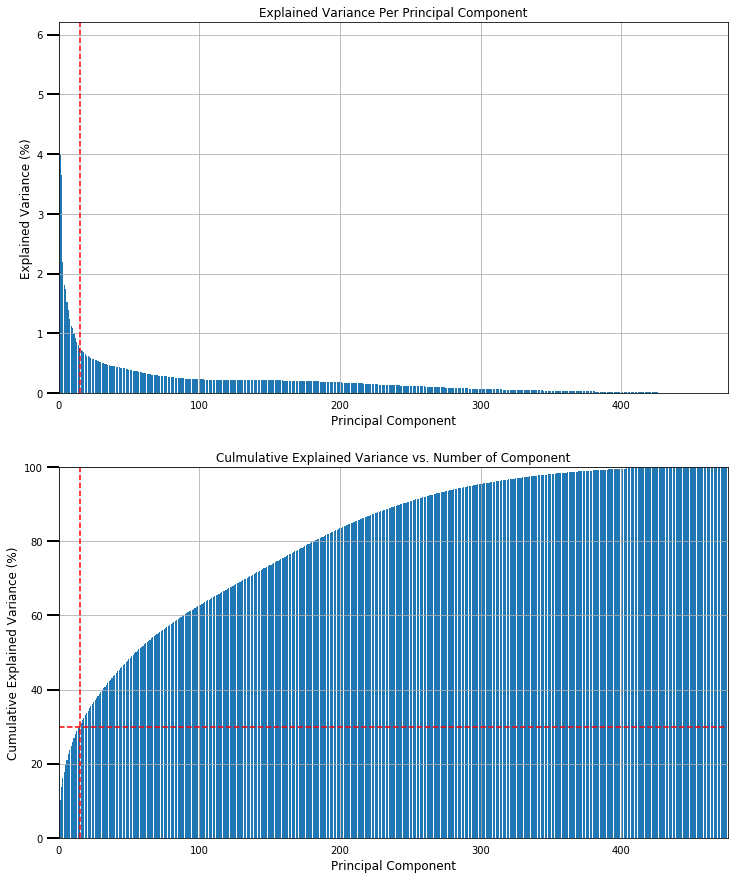

In [11]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca, var_thres = 30)

In [12]:
# Re-apply PCA to the data while selecting for number of components to retain.
n_components = 15 
pca = PCA(n_components = n_components)
azdias_scaled_pca = pca.fit_transform(azdias_scaled)
pca_filename = "savefile/pca.save"
joblib.dump(pca, pca_filename) 

['savefile/pca.save']

### Discussion

The scree plot shows that explained variance drops significantly around 15-th principal component, followed by a flat decaying tail afterward. At this sharp drop-off, the corresponding culmulative explained variance consists of 30% of total variance, as shown in the second plot. This could be considered as a good stopping point where additonal components do not contribute much to the explained variance. Based on above justifications, 15 principal components will be retained in the following analysis.

### Step 1.3: Interpret Principal Components

The first principal component to corresponding feature names, sorted by the weight: 


,Dimension,feature,PCA_Weight
0,Dimension 1,PLZ8_ANTG1,-0.1411
1,Dimension 1,KBA13_ANTG1,-0.1409
2,Dimension 1,PLZ8_ANTG3,0.1396
3,Dimension 1,KBA13_ANTG3,0.1396
4,Dimension 1,KBA13_ANTG4,0.1369
5,Dimension 1,KBA13_BAUMAX,0.1360
6,Dimension 1,PLZ8_ANTG4,0.1354
7,Dimension 1,WEALTH,0.1330
8,Dimension 1,MOBI_REGIO,-0.1323
9,Dimension 1,LP_STATUS_GROB_1.0,0.1320


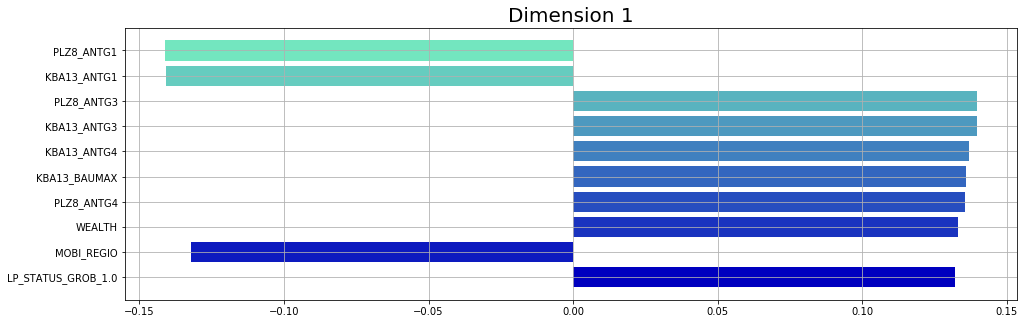

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

In [13]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# summarize the weights of each feature in all pca components
pca_weights = pca_weight_decomp(df_scaled, pca)
# show and save the top k features, sorted by their PCA weights in descending order
dim1 = show_pca_weight(pca_weights, topk_components = 4, topk_features = 10, \
                            kth_component = 1, figsize = (16,5), plot = True, print_screen = False)
print("The first principal component to corresponding feature names, sorted by the weight: ")
display(dim1)

The second principal component to corresponding feature names, sorted by the weight: 


,Dimension,feature,PCA_Weight
10,Dimension 2,KBA13_HERST_BMW_BENZ,0.1755
11,Dimension 2,KBA13_SEG_OBEREMITTELKLASSE,0.1500
12,Dimension 2,KBA13_MERCEDES,0.1500
13,Dimension 2,KBA13_BMW,0.1464
14,Dimension 2,KBA13_SITZE_5,-0.1457
15,Dimension 2,KBA13_SITZE_4,0.1443
16,Dimension 2,KBA13_SEG_SPORTWAGEN,0.1382
17,Dimension 2,KBA05_HERST1,0.1242
18,Dimension 2,KBA13_KMH_140_210,-0.1240
19,Dimension 2,KBA13_SEG_KLEINWAGEN,-0.1213


<Figure size 1152x360 with 0 Axes>

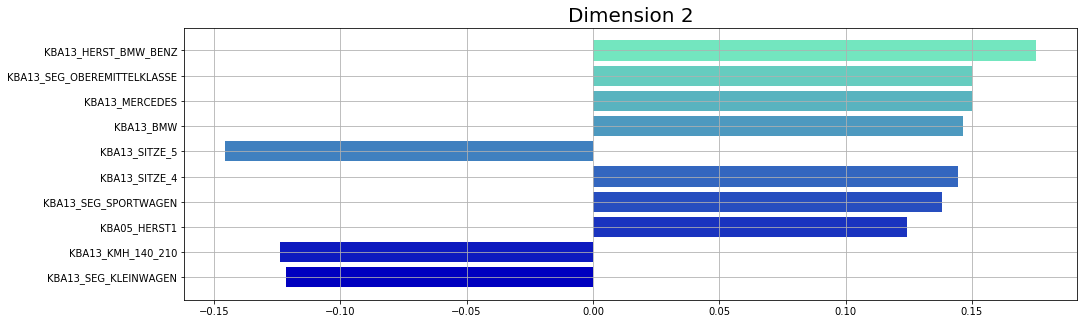

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

In [14]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
dim2 = show_pca_weight(pca_weights, topk_components = 4, topk_features = 10, \
                            kth_component = 2, figsize = (16,5), plot = True, print_screen = False)
print("The second principal component to corresponding feature names, sorted by the weight: ")
display(dim2)


The third principal component to corresponding feature names, sorted by the weight: 


,Dimension,feature,PCA_Weight
20,Dimension 3,DECADE,-0.1981
21,Dimension 3,CJT_TYP_1,-0.1945
22,Dimension 3,CJT_TYP_2,-0.1922
23,Dimension 3,FINANZ_SPARER,-0.1920
24,Dimension 3,ALTERSKATEGORIE_GROB,0.1830
25,Dimension 3,FINANZ_UNAUFFAELLIGER,-0.1785
26,Dimension 3,FINANZ_VORSORGER,0.1782
27,Dimension 3,CJT_TYP_5,0.1726
28,Dimension 3,CJT_TYP_4,0.1710
29,Dimension 3,CJT_TYP_3,0.1684


<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

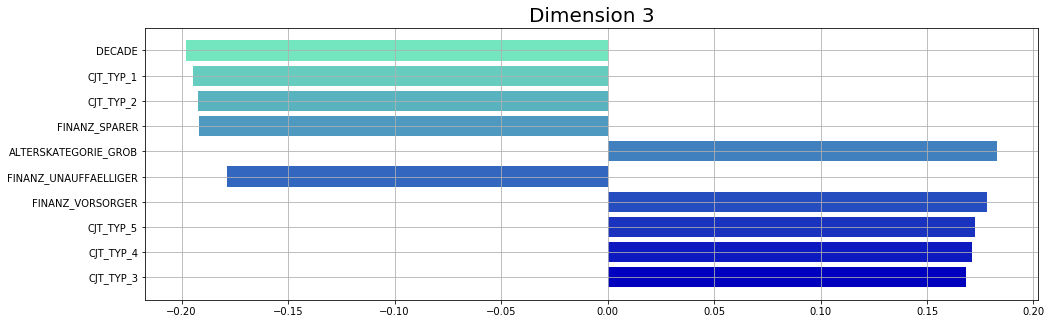

<Figure size 1152x360 with 0 Axes>

In [15]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
dim3 = show_pca_weight(pca_weights, topk_components = 4, topk_features = 10, \
                            kth_component = 3, figsize = (16,5), plot = True, print_screen = False)
print("The third principal component to corresponding feature names, sorted by the weight: ")
display(dim3)


### Step 1.3: Clustering

#### Step 1.3.1: Apply Clustering to General Population


In [15]:
clusters = np.arange(1, 30)
centers, scores = train_kmean(azdias_scaled_pca, clusters, batch_portion = 0.1, use_batch = True)

Input data dimension:  (785318, 15)
Using minibatch Kmean.
The score for 1 clusters is 110516658.43719487 
The score for 6 clusters is 75168001.90254937 
The score for 11 clusters is 67206501.36731102 
The score for 16 clusters is 61146885.94560835 
The score for 21 clusters is 58172393.46081451 
The score for 26 clusters is 55733450.57745879 


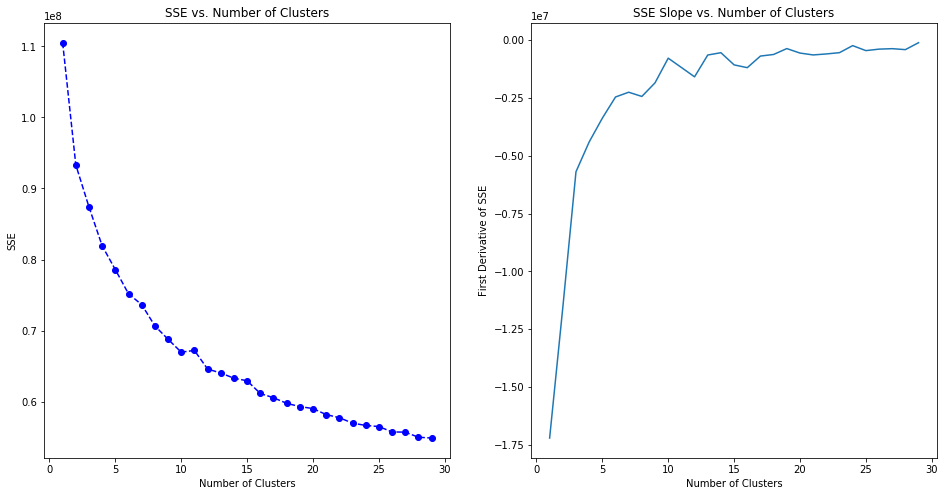

In [16]:
# Investigate the change in within-cluster distance across number of clusters.
plot_kmean_score(centers, scores)

In [16]:
n_clusters = 10
km = KMeans(n_clusters = n_clusters, random_state = 42)
model = km.fit(azdias_scaled_pca)
model_filename = "savefile/kmeans_model.save"
joblib.dump(model, model_filename)
# convert ndarray to dataframe object
azdias_label = pd.DataFrame({"Cluster_ID": model.predict(azdias_scaled_pca)})

df_azdias_scaled_pca = pd.DataFrame(data = azdias_scaled_pca, \
        columns = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)])
df_azdias_scaled_pca = pd.concat([df_azdias_scaled_pca, azdias_label], axis=1)

### Discussion

Based on the screeplot, 10-cluster seems to be a reasonable choice to segment the population. The scree plot on the left panel above shows that the average distance (SSE) decreases with the number of clusters monotonically. To find the elbow at which decreasing in the distance is not substantial enough to suggest the need for an additional cluster, I calculated their first derivative (the slope) with respect to the number of clusters, as shown in the right panel. With increased clusters, the slope starts to stablize around 10-15 clusters.

#### Step 1.3.2: Predict Cluster ID Based on Trained Model

In [24]:
azdias_cluster_ID = predict_cluster(azdias_processed, scaler, pca, model)
customers_cluster_ID = predict_cluster(customers_processed, scaler, pca, model)
X_train_cluster_ID = predict_cluster(X_train_processed, scaler, pca, model)
X_test_cluster_ID = predict_cluster(X_test_processed, scaler, pca, model)

In [25]:
# predict cluster ID for train data
#X_train_cluster_ID = predict_cluster(X_train_processed, scaler, pca, model)
X_train_labeled = X_train[['LNR']].merge(X_train_cluster_ID, how = 'left', on = 'LNR')
X_train_labeled.Cluster_ID.fillna(value = 10, inplace = True)
X_train_labeled.to_csv('arvato_data/train_cluster_ID.csv', sep = '\t')
# predict cluster ID for test data
#X_test_cluster_ID = predict_cluster(X_test_processed, scaler, pca, model)
X_test_labeled = X_test[['LNR']].merge(X_test_cluster_ID, how = 'left', on = 'LNR')
X_test_labeled.Cluster_ID.fillna(value = 10, inplace = True)
X_test_labeled.to_csv('arvato_data/test_cluster_ID.csv', sep = '\t')

In [26]:
# separate into response/no response data for plotting
X_train_0 = X_train[y_train['RESPONSE'] == 0]
X_train_1 = X_train[y_train['RESPONSE'] == 1]
X_train_0_cluster_ID = X_train_cluster_ID[X_train_cluster_ID.index.isin(y_train[y_train['RESPONSE']==0].index)]
X_train_1_cluster_ID = X_train_cluster_ID[X_train_cluster_ID.index.isin(y_train[y_train['RESPONSE']==1].index)]

#### Step 1.3.3: Compare Customer Data to Demographics Data

#### Distribution of General Demographic and Customers

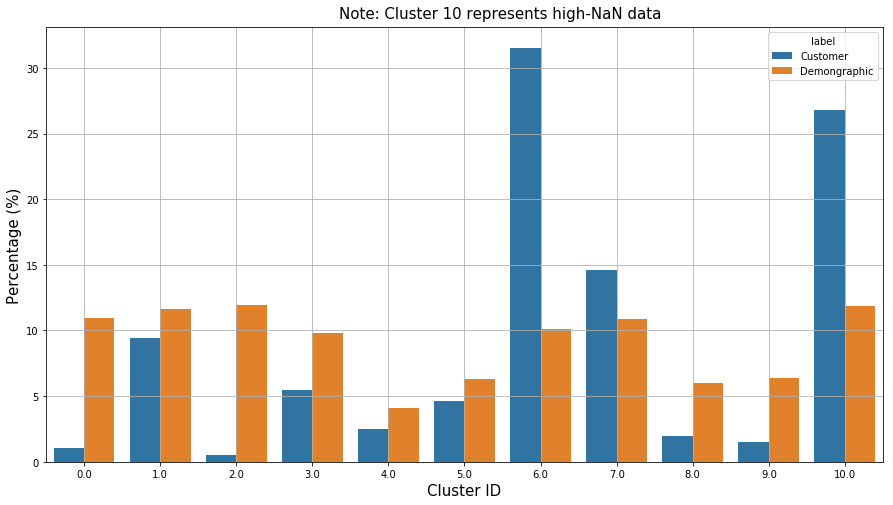

In [27]:
df_agg0 = segment_plot(azdias, customers, azdias_cluster_ID, customers_cluster_ID)

#### Distribution of Response/No Response Customers in the Mail-Out Campaign

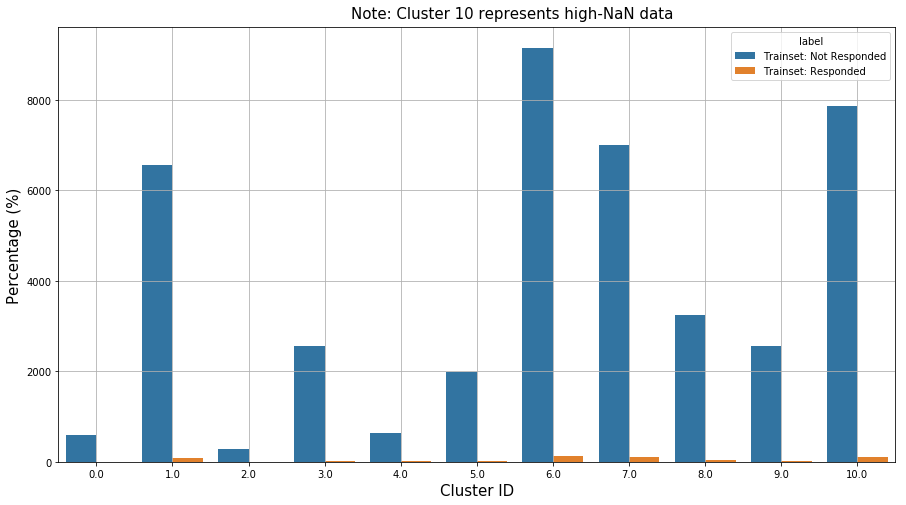

In [28]:
df_agg1 = segment_plot(X_train_0, X_train_1, X_train_0_cluster_ID, X_train_1_cluster_ID, \
                       normalized = False, labels = ['Trainset: Not Responded', 'Trainset: Responded'])

#### Detail Statistics of Customers who responded

In [29]:
df_agg1['Response_Rate'] = df_agg1.groupby(by = ['Cluster_ID'])[['Count']].transform(lambda x: (x/ x.sum())*100)
df_agg1[df_agg1['label'] == 'Trainset: Responded'].sort_values(by='Frequency', ascending = False)

,label,Cluster_ID,Count,Frequency,Response_Rate
17,Trainset: Responded,6.0,139,26.127820,1.495589
18,Trainset: Responded,7.0,98,18.421053,1.380282
21,Trainset: Responded,10.0,97,18.233083,1.217828
12,Trainset: Responded,1.0,80,15.037594,1.205001
19,Trainset: Responded,8.0,35,6.578947,1.069029
16,Trainset: Responded,5.0,25,4.699248,1.245640
20,Trainset: Responded,9.0,20,3.759398,0.776699
14,Trainset: Responded,3.0,18,3.383459,0.697404
15,Trainset: Responded,4.0,11,2.067669,1.726845
11,Trainset: Responded,0.0,5,0.939850,0.822368


In [2]:
# What kinds of people are part of a cluster that is overrepresented/underrepresented in the
# customer data compared to the general population?
show_attributes(6, 2)

Cluster 14 (overrepresenting)  \
Income             HH_EINKOMMEN_SCORE   Estimated household net income                       2.499271   
                   LP_STATUS_GROB_1.0   low-income earners                                  -0.005925   
                   LP_STATUS_GROB_2.0   average earners                                      0.183684   
                   LP_STATUS_GROB_3.0   independents                                         0.086453   
                   LP_STATUS_GROB_4.0   houseowners                                          0.133851   
                   LP_STATUS_GROB_5.0   top earners                                          0.601937   
                   FINANZ_MINIMALIST    low financial interest                               4.443390   
                   WEALTH               Wealth Scale                                         1.949191   
Age                ALTERSKATEGORIE_GROB Estimated age                                        3.296425   
                   DECADE               Borned Decades                                       3.494692   
Gender             ANREDE_KZ_1          Male                                                 0.523486   
                   ANREDE_KZ_2          Female                                               0.476514   
Movement           GREEN_AVANTGARDE_0   mainstream                                           0.177629   
                   GREEN_AVANTGARDE_1   avantgarde                                           0.822371   
                   MOVEMENT             mainstream vs. avantgarde                            0.822371   
Apartment Location OST_WEST_KZ_O        East Germany                                         0.068062   
                   OST_WEST_KZ_W        West Germany                                         0.931938   

                                                                        Cluster 5 (underrepresenting)  
Income             HH_EINKOMMEN_SCORE   Estimated household net income                       5.001463  
                   LP_STATUS_GROB_1.0   low-income earners                                   0.545940  
                   LP_STATUS_GROB_2.0   average earners                                      0.320937  
                   LP_STATUS_GROB_3.0   independents                                         0.002391  
                   LP_STATUS_GROB_4.0   houseowners                                          0.112071  
                   LP_STATUS_GROB_5.0   top earners                                          0.018660  
                   FINANZ_MINIMALIST    low financial interest                               1.955474  
                   WEALTH               Wealth Scale                                         3.334989  
Age                ALTERSKATEGORIE_GROB Estimated age                                        1.940437  
                   DECADE               Borned Decades                                       5.635243  
Gender             ANREDE_KZ_1          Male                                                 0.389082  
                   ANREDE_KZ_2          Female                                               0.610918  
Movement           GREEN_AVANTGARDE_0   mainstream                                           0.911557  
                   GREEN_AVANTGARDE_1   avantgarde                                           0.088443  
                   MOVEMENT             mainstream vs. avantgarde                            0.088443  
Apartment Location OST_WEST_KZ_O        East Germany                                         0.052931  
                   OST_WEST_KZ_W        West Germany                                         0.947069

### Discussion

By applying the clustering analysis, each individual can be divided into 10 clusters. In addition, all high-NaN data has been assigned into Cluster 10. The first figure on the top shows a comparison of distribution between the general demongraphics, and the customer. In the unsupervised learning project (Notebook via this <a href="https://github.com/Zhitaow/Identify_Customer_Segments/blob/main/Identify_Customer_Segments.ipynb">LINK</a>), we already concluded that stongger base of becoming the customer lies in the cluster where the population of customer overrepresents the general demongraphics. In this case, it is the cluster 6, 7, and 10. 

Based on the table above, we can concluded that the most overrepresenting cluster is the group of people, with high-income in their middle-age borned in 40-50s, involved in green avantgarde, and mostly living in the area of former West Germany. People in the underrepresenting cluster trend to be on the opposite side: they are lower income earners, mainly younger female borned in the 80-90s, and not a member of green avantgarde.

The second figure above show the distribution of targeted individuals in the mailout campain, similar to the distribution of the customer clusters in the first figure. The color indicates pepople who responded (orange), and not responded (blue). The table above shows detailed statistics about the individuals who responded in the mail-out campain. Most mail-out individuals fall into bucket Cluster 6, 7 and 10, with response rate slightly above 1%.

Overall, the response rate is similar in each cluster, with only about 1 percentage on average. To build a supervised-learning model which predicts the likelihood of an individual to respond, we need to re-balance the dataset. There are generally two ways: changing the weights on the labeled data, sampling strategy. Here, I used the oversampling method, as shown in the next part. 


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

## Step 2.1 Data Preprocessing

### 2.1.1 Restore saved files generated from Part 1

You can skip Part 0 and Part 1, and restore savefiles from previous steps.

In [2]:
# load missing codes obtained from the dictionary 
feat_nan_code = pd.read_csv('arvato_data/feature_missing_code.csv', sep = '\t').drop('Unnamed: 0', axis = 1)
# load feature type obtained from the dictionary
feat_cat = pd.read_csv('arvato_data/feature_type.csv', sep = '\t').drop('Unnamed: 0', axis = 1)
# load feature to be dropped obtained from Step 0.3.1
feature_to_drop = pd.read_csv('arvato_data/dropped_feature.csv')
# some formatting steps
X = 'X'
XX = 'XX'
feat_nan_code['Value'] = feat_nan_code['Value'].apply(lambda x: eval(x))
# load clustering model obtained from Step 1
km = joblib.load("savefile/kmeans_model.save")
# load standard scaler obtained from step 1
km_scaler = joblib.load("savefile/standard_scaler.save") 
# load pca obtained from step 1
km_pca = joblib.load("savefile/pca.save") 
# load dataset
mailout_train = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', dtype={19:'str',20:'str'}).drop('Unnamed: 0', axis = 1)
# load predicted cluster_IDs obtained from step 1
mailout_train_cluster = pd.read_csv('arvato_data/train_cluster_ID.csv', sep = '\t').drop('Unnamed: 0', axis = 1)
# load list of all column names after cleaning azdias data in step 1 
azdias_processed_columns = list(pd.read_csv('savefile/all_columns.csv').drop('Unnamed: 0', axis = 1).iloc[:,0])

### 2.1.2 Clean and Split the Data

The data cleaning step is similar to Part 1: in stead of dropping the data above the row-missing threshold, we impute them with the mode in the corresponding column. A stratified splitting approach on the label was used to obtain training (75%) and testing sets (25%) with approximatly similar portion of response/no response samples.

In [3]:
X = mailout_train.drop(['RESPONSE'], axis = 1)
y = mailout_train[['LNR', 'RESPONSE']].astype(float)
# similar data cleaning procedures to Step 1
X_cleaned, X_nan = clean_data(X, feat_nan_code, feat_cat, feature_to_drop = feature_to_drop, row_thres = 30, drop_row_NaN = False, print_step = False)
# data columns after cleaning should be exactly the same as before
X_cleaned = reshape_cols(X_cleaned, azdias_processed_columns)
# merge predicted clustering IDs generated from Step 1
X_cleaned = X_cleaned.merge(mailout_train_cluster, how = 'left', on = 'LNR')
# use stratified splitting to generate trainset and testset
X_train_cleaned, X_test_cleaned, y_train, y_test = train_test_split_by_cluster(X_cleaned, y, \
                                                                               test_size=0.25, random_state=1)
#X_train_cleaned, X_test_cleaned, y_train, y_test = train_test_split(X_cleaned, y, test_size=0.2, \
#                                                                    stratify = y.RESPONSE, random_state=1)


 The new dataset dimension is: (42962, 476)

 Sanity Check: The dimension of the dataset is: (42962, 476)
There are 0 columns of non-numeric dtype.
There are 0 columns containing missing values.


### 2.1.3 Oversampling

For each cluster, I bootstraped the data labeled with response (y=1) to the same amount of no response (y=0) for each cluster.

In [4]:
train_set = pd.concat([y_train, X_train_cleaned.drop(columns='LNR')], axis = 1)
n_clusters = train_set.Cluster_ID.nunique()
train_over_cluster = pd.DataFrame(data=None, columns = train_set.columns)
for Cluster_ID in range(n_clusters):
    train_over_cluster = pd.concat([train_over_cluster, oversampling(train_set, Cluster_ID)])
# shuffle the data
train_over_cluster = train_over_cluster.sample(frac=1).reset_index(drop=True)
X_train_over = train_over_cluster.drop(['RESPONSE'], axis = 1)
y_train_over = train_over_cluster[['LNR', 'RESPONSE']]

## Step 2.2 Train the Model

Now that all values in the data have been converted to numerics that a machine learning algorithm can interpret, we can train different models and compare their performance. There are several models we can consider, from KNN, Logistic Regression to ensemble methods (such as Random Forest Decision Tree, Gradient Boosting Decision Tree). 

The coding cells below show examples of KNN, Random Forest, XGBoost and LGBoost. They were trained with 5-fold cross-validation via implementing the GridSearchCV. By trying different combination of hyperparameters, GridSearchCV will return the optimal model based on the metric: Receiver Operator Characteristic Under the Curve (ROC-AUC). 

Finally, the best-fit model was then validated by the AUC on the test set. By comparing AUC scores of training and testing data, we can determine the optimal hyperparameters of the model. In a senario when the model scores significantly higher on the train set than the test set (overfitting), we can often reduce step size: the learning rate. For tree-based models, we can also reduce the tree depth and the number of base tree, etc.

### 2.2.1 K-Nearest-Neighbor

# {'n_neighbors': 500, 'weights': 'uniform'} 0.65413582118
Trainset  AUC Score:  0.672678488861
Testset  AUC Score:  0.57045359929
Training Time: 16.74738724629084 min


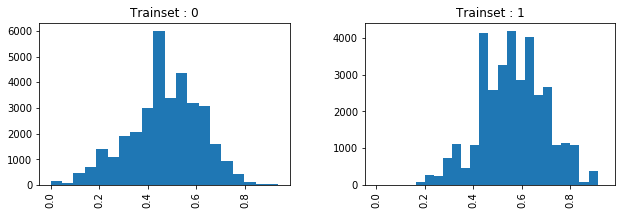

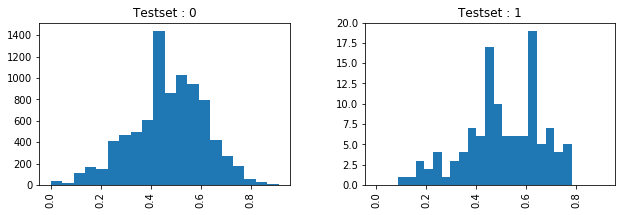

In [5]:
param_grid = {
    'n_neighbors': [500],
    'weights':['uniform'], 
}

estimator = KNeighborsRegressor(n_jobs = 2)
best_estimator_KNN, pred_result_KNN, auc_score_KNN, _ = my_gridsearch(estimator = estimator, param_grid = param_grid, \
              X_train = X_train_over.drop(columns = ['LNR', 'Cluster_ID']), y_train = y_train_over, \
              X_test = X_test_cleaned, y_test = y_test)

### 2.2.2 Random Forest Decision Tree

# {'max_depth': 4, 'max_features': 280, 'n_estimators': 210} 0.836589007464
Trainset  AUC Score:  0.838255320854
Testset  AUC Score:  0.766558077579
Training Time: 3.077898681163788 min


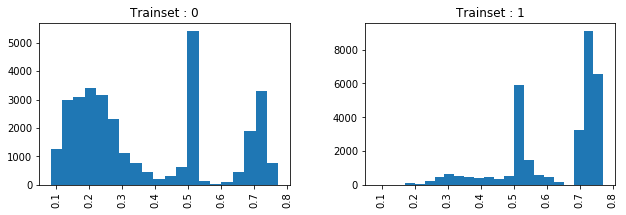

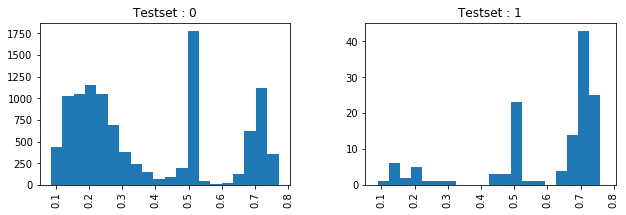

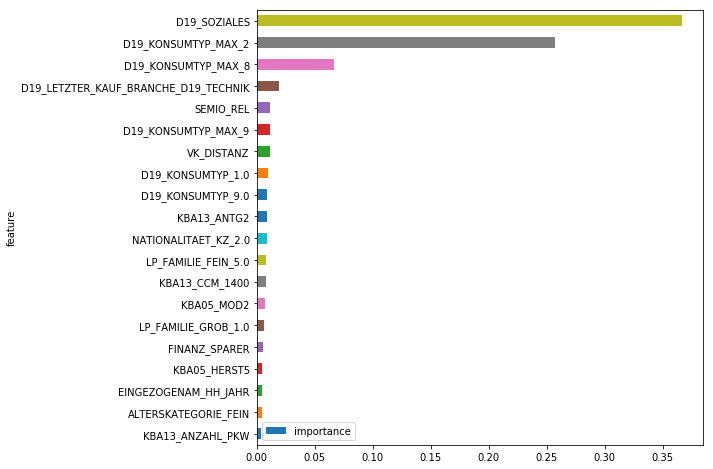

In [5]:
param_grid = {
    'max_depth': [4],
    'n_estimators':[210], 
    'max_features':[280]
}
estimator = RandomForestRegressor(random_state=0, n_jobs = 2)

best_estimator_RF, pred_result_RF, auc_score_RF, feature_importances_RF = my_gridsearch(estimator = estimator, param_grid = param_grid, \
              X_train = X_train_over.drop(columns = ['LNR', 'Cluster_ID']), y_train = y_train_over, \
              X_test = X_test_cleaned, y_test = y_test)

In [6]:
evaluate_models([best_estimator_RF], X_train_over, y_train_over, X_test_cleaned, y_test)

Overall Train Score: 0.8382553208537138, Test: 0.7665580775793074


,Cluster_ID,AUC train_x,Train Count: 0_x,Train Count: 1_x,AUC train_y,Train Count: 0_y,Train Count: 1_y
0,0,0.977950,452,452,0.940397,151,1
1,1,0.911754,4919,4919,0.802485,1640,20
2,2,0.868181,208,208,0.885714,70,1
3,3,0.858246,1922,1922,0.886115,641,5
4,4,0.837962,469,469,0.719745,157,3
5,5,0.839730,1486,1486,0.850134,496,6
6,6,0.835738,6866,6866,0.719828,2289,35
7,7,0.838331,5252,5252,0.830423,1750,25
8,8,0.908210,2429,2429,0.650343,810,9
9,9,0.941741,1916,1916,0.807199,639,5


In [9]:
model_filename = "savefile/RF_model4.save"
joblib.dump(best_estimator_RF, model_filename)

['savefile/RF_model4.save']

### 2.2.3 XGBoost

# {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 1500, 'reg_lambda': 0} 0.809073631125
Trainset  AUC Score:  0.81009561431
Testset  AUC Score:  0.765674736299
Training Time: 41.345033963521324 min


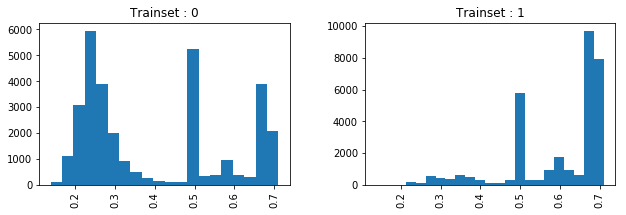

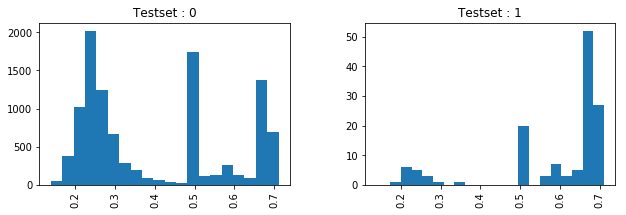

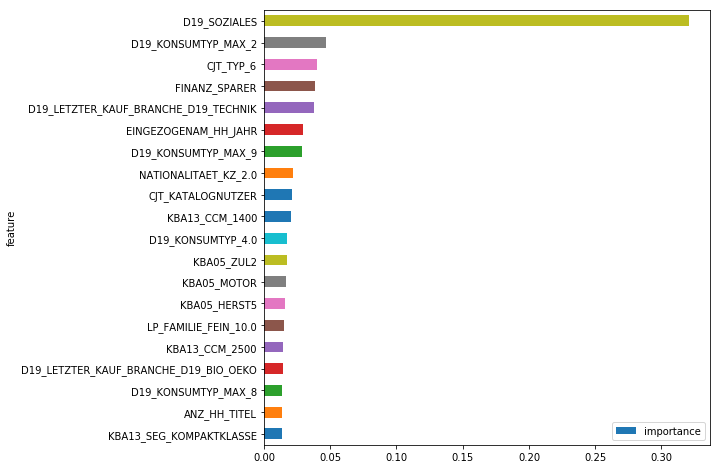

In [7]:
param_grid = {
    'n_estimators':[1500],
    'max_depth':[3],
    'learning_rate': [0.001], 
    #'reg_alpha': [0.04]
    'reg_lambda': [0]
}

estimator =  XGBRegressor(n_jobs = 2)
best_estimator_XGB, pred_result_XGB, auc_score_XGB, feature_importances_XGB = my_gridsearch(estimator = estimator, param_grid = param_grid, \
              X_train = X_train_over.drop(columns = ['LNR', 'Cluster_ID']), y_train = y_train_over, \
              X_test = X_test_cleaned, y_test = y_test)

In [8]:
evaluate_models([best_estimator_XGB], X_train_over, y_train_over, X_test_cleaned, y_test)

Overall Train Score: 0.8100956143103029, Test: 0.7656747362987156


,Cluster_ID,AUC train_x,Train Count: 0_x,Train Count: 1_x,AUC train_y,Train Count: 0_y,Train Count: 1_y
0,0,0.959859,452,452,0.927152,151,1
1,1,0.882026,4919,4919,0.748110,1640,20
2,2,0.829350,208,208,0.942857,70,1
3,3,0.828550,1922,1922,0.865055,641,5
4,4,0.805702,469,469,0.653928,157,3
5,5,0.830856,1486,1486,0.851647,496,6
6,6,0.793017,6866,6866,0.717993,2289,35
7,7,0.802805,5252,5252,0.856869,1750,25
8,8,0.869024,2429,2429,0.663374,810,9
9,9,0.913249,1916,1916,0.832551,639,5


In [10]:
model_filename = "savefile/XGB_model4.save"
joblib.dump(best_estimator_XGB, model_filename)

['savefile/XGB_model4.save']

### 2.2.4 LGBM

# {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 2000} 0.819993585574
Trainset  AUC Score:  0.82165553907
Testset  AUC Score:  0.762487041749
Training Time: 3.3031233151753745 min


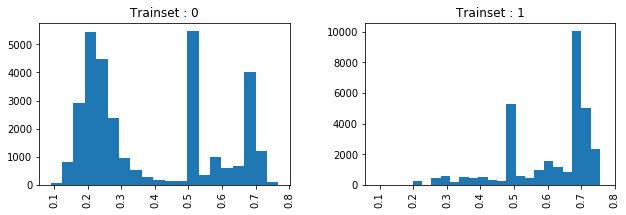

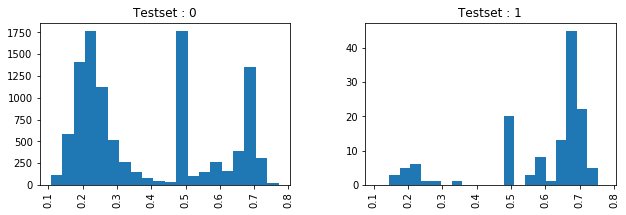

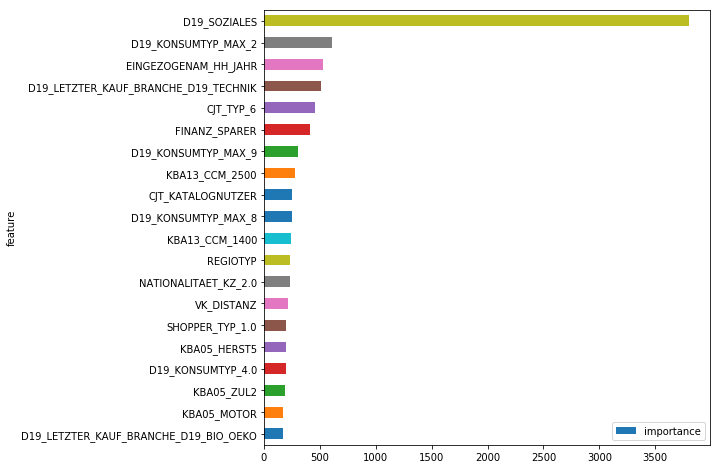

In [11]:
param_grid = {
              #'max_bin': [5],
              #'num_leaves': [4],
              'learning_rate' : [0.001],
              'max_depth': [3],
              'n_estimators' : [2000] 
             }
estimator = LGBMRegressor(n_jobs =2, random_state=0)
best_estimator_LGB, pred_result_LGB, auc_score_LGB, feature_importances_LGB = my_gridsearch(estimator = estimator, param_grid = param_grid, \
              X_train = X_train_over.drop(columns = ['LNR', 'Cluster_ID']), y_train = y_train_over, \
              X_test = X_test_cleaned, y_test = y_test)

Overall Train Score: 0.8216555390697939, Test: 0.7624870417491282


,Cluster_ID,AUC train_x,Train Count: 0_x,Train Count: 1_x,AUC train_y,Train Count: 0_y,Train Count: 1_y
0,0,0.966144,452,452,0.953642,151,1
1,1,0.894661,4919,4919,0.720762,1640,20
2,2,0.850569,208,208,0.928571,70,1
3,3,0.857131,1922,1922,0.865835,641,5
4,4,0.810223,469,469,0.679406,157,3
5,5,0.839439,1486,1486,0.831149,496,6
6,6,0.817779,6866,6866,0.719466,2289,35
7,7,0.819196,5252,5252,0.857143,1750,25
8,8,0.880496,2429,2429,0.665706,810,9
9,9,0.920863,1916,1916,0.827074,639,5


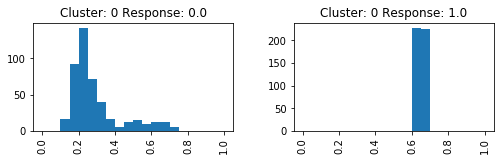

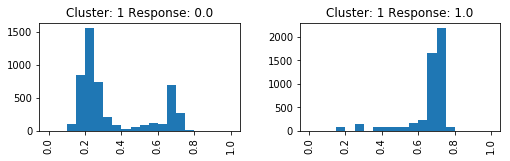

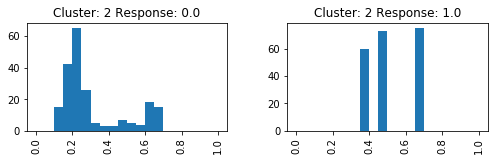

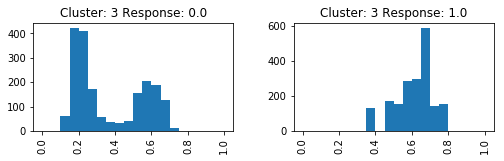

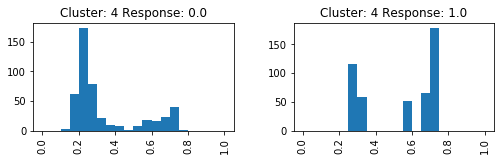

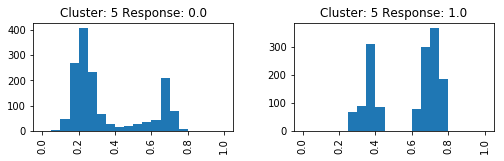

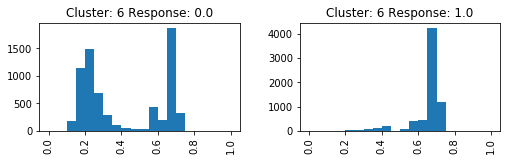

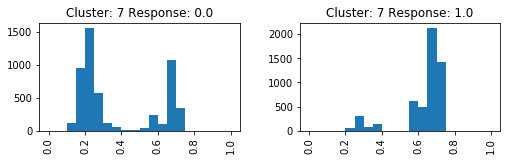

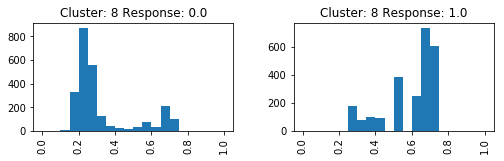

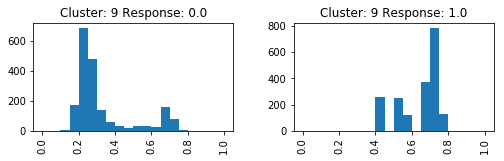

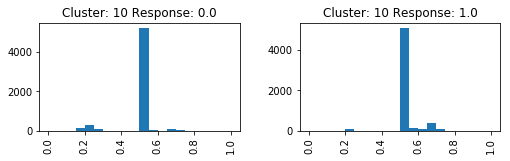

In [27]:
evaluate_models([best_estimator_LGB], X_train_over, y_train_over, X_test_cleaned, y_test, plot_train = True)

In [13]:
model_filename = "savefile/LGB_model4.save"
joblib.dump(best_estimator_LGB, model_filename)

['savefile/LGB_model4.save']

### Discussion

The first 2x2 figures in each model show the histograms of predicted probabilities for each class: without response (left panel) and with response (right panel). The top two panels correspond to the train set, and the bottom two panels to the test set. 

Ideally, we would like to have a classifier with 100% AUC, which corresponds to all true negative (no response) falls on 0-bucket in the left panel, and all true positive (response) falls on the 1-bucket in the right panel. A worse classifier corresponds to the scenario that the distribution of true positive and true negative are inseparable, which can be illustrated by the KNN result, with only about 67% AUC on the train set and 57% on the test set.

Overall, XGBoost or LGBM algorithms show the best performance with very similar AUC scores, the computation time of LGBM is significantly faster than XGBoost. In my case, I have chosen LGBM for the convenience of tuning the hyperparameters. 

The second figures in each model show features based on top-ranked feature importance. All three tree-base algorithms have sucessfully foudn that **D19_SOZIALES** is the most important features to classify the samples.

The tables just below show more details about the AUC scores on the trainset (Column **AUC train_x**) and testset (Column **AUC train_y**). Each row responds to the AUC scores on the corresponding cluster, ordered in Cluster 0-10. Columns **Train Count: 1_x** and **Train Count: 0_x** show the total count of sample with/without response in the trainset. Similarily, **Train Count: 1_y** and **Train Count: 0_y** are the sample counts in the testset.

Note that a marginal difference in AUC between the trainset and testset may not suggest under/over-fitting, since there is not enough statstics to learn from. This is especially true in the case of Cluster 0, and 2. However, cluster 6, 7 and 10 are somehow worthwhile to look at.

We can decompose the distribution of true positive and negative into different clusters, as shown in the figure just below the table in the code cell **Line 27** (scroll down in the box). Notice that Cluster 10 has only about 50-60% AUC, which can be visualized here. Most samples of true positive and negative are almost inseparable, spiking near 0.5 of predicted probability on the x-axis, which is responsible for the spike near 0.5 in the all-cluster distribution. The poor AUC in Cluster 10 is very likely due to limited amount of features we can use for prediction (recall that Cluster 10 corresponds to high row-missing data).  

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

## 3.1 Modeling Agumentation

### 3.1.1 Augmentation by Model Ensembles

Now that we have trained different models, it is a good idea to combine them by averaging their predicted probabilities. The table below shows that the corresponding AUCs based on the three algorithms: Random Forest, XGBoost and LGBM. Overall, combining these models as an ensemble seems to slightly improve the training and testing AUCs. 

In [14]:
# load supervised-learning models from step 2.2
best_estimator_RF = joblib.load("savefile/RF_model4.save")
best_estimator_XGB = joblib.load("savefile/XGB_model4.save")
# general predictor
best_estimator_LGB = joblib.load("savefile/LGB_model4.save")
# one-cluster predictor
best_estimator_cluster6 = joblib.load("savefile/LGB_model_cluster6.save")

Overall Train Score: 0.8307156375689417, Test: 0.7666554842412198


,Cluster_ID,AUC train_x,Train Count: 0_x,Train Count: 1_x,AUC train_y,Train Count: 0_y,Train Count: 1_y
0,0,0.968640,452,452,0.933775,151,1
1,1,0.906811,4919,4919,0.761280,1640,20
2,2,0.859005,208,208,0.928571,70,1
3,3,0.847030,1922,1922,0.875819,641,5
4,4,0.829488,469,469,0.660297,157,3
5,5,0.848670,1486,1486,0.825269,496,6
6,6,0.825188,6866,6866,0.718105,2289,35
7,7,0.832876,5252,5252,0.848617,1750,25
8,8,0.895431,2429,2429,0.646365,810,9
9,9,0.933679,1916,1916,0.818153,639,5


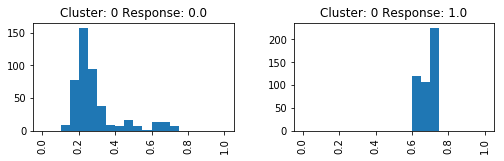

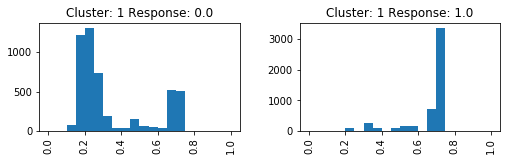

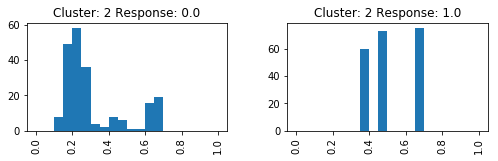

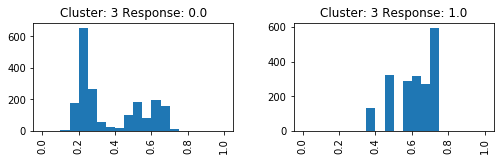

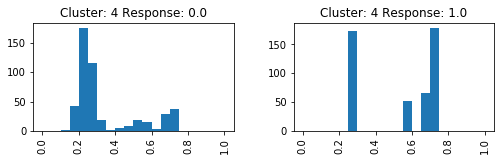

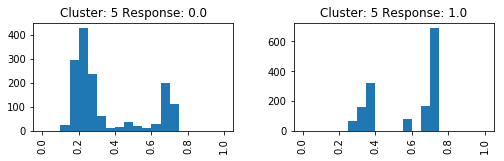

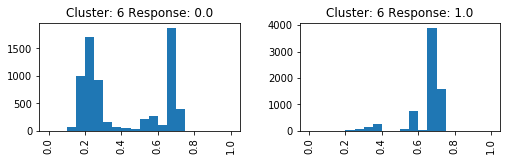

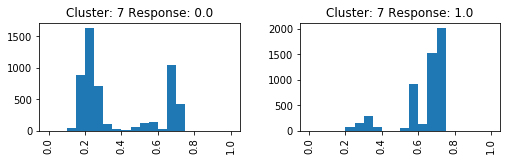

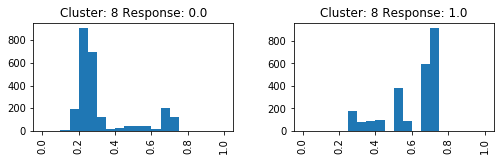

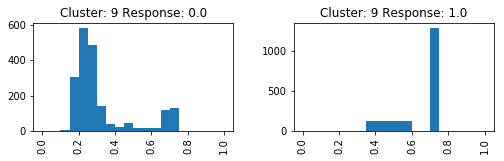

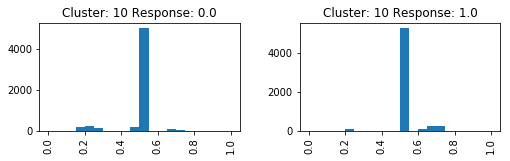

In [15]:
# combine average predictions by model ensembles
evaluate_models([best_estimator_RF, best_estimator_XGB, best_estimator_LGB], X_train_over, y_train_over, X_test_cleaned, y_test, plot_train = True)

### 3.1.2 Augmentation by Clusters

Another way to improve the AUC socre is by aggregating multiple cluster-based classifiers to the general classifier. Specifically speaking, we can train one classifier focusing on each specific cluster, and improve the corresponding AUC scores. The final probabilities are the average of the probabilities of the cluster classifier and the general classifier on the corresponding cluster. 

The cells below show an example of training a classifier only for cluster-6 customer data, which consists of 26% of all clusters. After training, I obtained AUC scores of 0.8192 and 0.7705 on the trainset and testset, compared to AUC scores of 0.8177 and 0.7181 of a general classifier (see Part 2.2.4 LGBM table, cluster 6), which is an significant improvement on the testset.

Note that the ranked features are also different from the features of a general classifers. For cluster-6 group, GEBAEUDETYP (building type) is the secondary important feature.

In [16]:
# create a Cluster-6 subset  
Cluster_ID = 6
X_train_subset = X_train_over[X_train_over.Cluster_ID == Cluster_ID]
y_train_subset = y_train_over[X_train_over.Cluster_ID == Cluster_ID]
X_test_subset = X_test_cleaned[X_test_cleaned.Cluster_ID == Cluster_ID]
y_test_subset = y_test[X_test_cleaned.Cluster_ID == Cluster_ID]

In [17]:
# set LGBM hyperparameters
param_grid = {
              #'max_bin': [5],
              #'num_leaves': [4],
              'learning_rate' : [0.0005],
              'max_depth': [3],
              'n_estimators' : [800]
             }

estimator = LGBMRegressor(n_jobs =2, random_state=0)

# {'learning_rate': 0.0005, 'max_depth': 3, 'n_estimators': 800} 0.81244327766
Trainset  AUC Score:  0.819238047738
Testset  AUC Score:  0.770504899207
Training Time: 0.1452768325805664 min


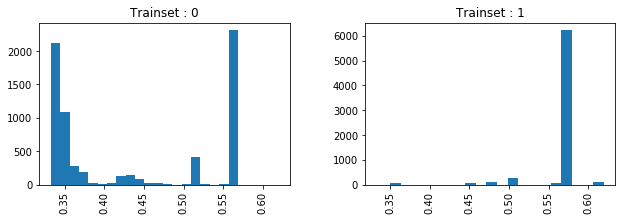

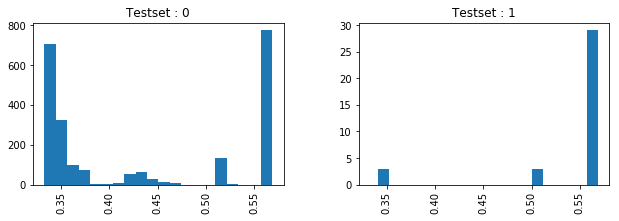

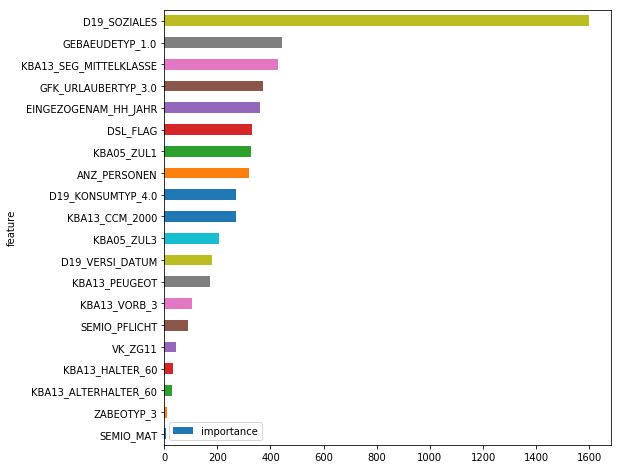

In [18]:
best_estimator_cluster6, pred_result_cluster6, \
    auc_score_cluster6, feature_importances_cluster6 = \
              my_gridsearch(estimator = estimator, param_grid = param_grid, \
              X_train = X_train_subset.drop(columns = ['LNR', 'Cluster_ID']), y_train = y_train_subset, \
              X_test = X_test_subset, y_test = y_test_subset, cv = 2)

The cells below show an example of combining the trained cluster-6 classifier with the general classifier of LGBM model (obtained from Part 2.2.4). Overall, due to the improvement on cluster 6, the AUC score of all clusters on the trainset has been slightly improved from 0.82165553907 (General  AUC Score) to 0.826072236163 (General_Cluster AUC Score), and the AUC score on the testset from 0.762487041749 to 0.766504275344.

(The tables below the cells show general statistics of Cluster 6 before (column: LGB) and after (column: General_Cluster) adding a cluster classifier.)




### Comparison of AUCs before and after the Cluster Augmentation on Trainset

General  AUC Score:  0.82165553907
General_Cluster AUC Score:  0.826072236163


,LNR,RESPONSE,Cluster_ID,LGB,Average,Cluster_Align,General_Cluster
count,63638.000000,63638.000000,63638.000000,63638.000000,63638.000000,63638.000000,63638.000000
mean,42348.584808,0.500000,6.098337,0.500000,0.500000,0.500000,0.500000
std,24286.077806,0.500004,3.016573,0.197202,0.197202,0.197202,0.196172
min,1.000000,0.000000,0.000000,0.089461,0.089461,0.089461,0.089461
25%,21200.000000,0.000000,4.000000,0.276491,0.276491,0.272743,0.275111
50%,42415.000000,0.500000,6.000000,0.503343,0.503343,0.503343,0.503343
75%,62987.000000,1.000000,8.000000,0.687024,0.687024,0.676879,0.683598
max,85795.000000,1.000000,10.000000,0.768108,0.768108,0.785340,0.768108


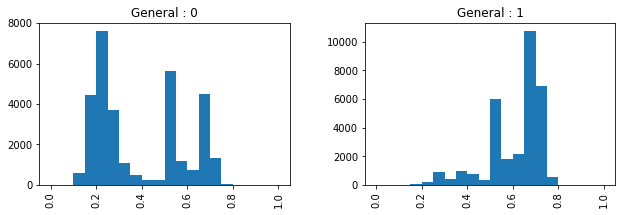

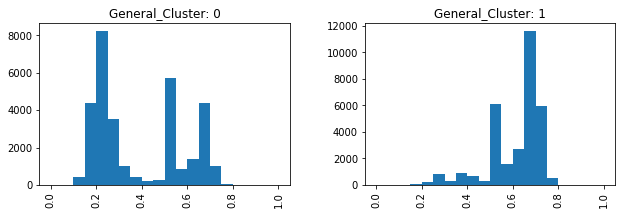

In [19]:
df_train_result = cluster_predict(best_estimator_LGB, best_estimator_cluster6, X_train_over, y_train_over, 6, plot = True)
df_train_result.describe()

### Comparison of AUCs before and after the Cluster Augmentation on Testset

General  AUC Score:  0.762487041749
General_Cluster AUC Score:  0.766504275344


,LNR,RESPONSE,Cluster_ID,LGB,Average,Cluster_Align,General_Cluster
count,10745.000000,10745.000000,10745.000000,10745.000000,10745.000000,10745.000000,10745.000000
mean,42810.354211,0.012471,6.098371,0.391202,0.391202,0.391202,0.391202
std,24823.351634,0.110980,3.015211,0.195692,0.195692,0.195692,0.194572
min,5.000000,0.000000,0.000000,0.107762,0.107762,0.110290,0.110290
25%,21390.000000,0.000000,4.000000,0.216640,0.216640,0.214805,0.217826
50%,42618.000000,0.000000,6.000000,0.294326,0.294326,0.286031,0.289052
75%,64607.000000,0.000000,8.000000,0.556510,0.556510,0.540004,0.545182
max,85771.000000,1.000000,10.000000,0.771391,0.771391,0.771391,0.771391


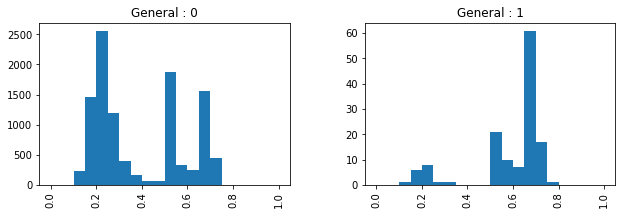

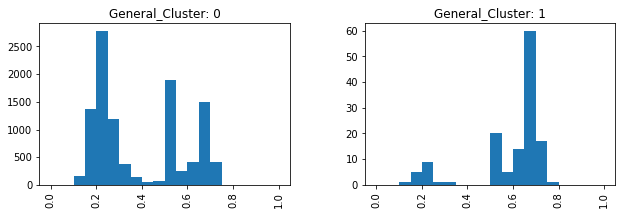

In [20]:
df_test_result = cluster_predict(best_estimator_LGB, best_estimator_cluster6, X_test_cleaned, y_test, 6, plot = True)
df_test_result.describe()

#### Save the Cluster Model

In [25]:
model_filename = "savefile/LGB_model_cluster.save"
joblib.dump(best_estimator_cluster6, model_filename)

['savefile/LGB_model_cluster.save']

### 3.1.3 Submission to Kaggle

In [21]:
# load testing dataset
mailout_test = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';', dtype={19:'str',20:'str'}).drop(columns = 'Unnamed: 0')
# load predicted cluster_IDs obtained from step 1
mailout_test_cluster = pd.read_csv('arvato_data/test_cluster_ID.csv', sep = '\t').drop('Unnamed: 0', axis = 1)
# data preprocessing
X = mailout_test
ID = mailout_test[['LNR']]
X_cleaned, X_nan = clean_data(X, feat_nan_code, feat_cat, feature_to_drop = feature_to_drop, row_thres = 30, drop_row_NaN = False, print_step = False)
X_kaggle = reshape_cols(X_cleaned, azdias_processed_columns)
X_kaggle = X_kaggle.merge(mailout_test_cluster, how = 'left', on = 'LNR')
y_kaggle = X_kaggle[['LNR']].copy().astype(int)
y_kaggle['RESPONSE'] = np.nan


 The new dataset dimension is: (42833, 476)

 Sanity Check: The dimension of the dataset is: (42833, 476)
There are 0 columns of non-numeric dtype.
There are 0 columns containing missing values.


#### Submit Predictions by a General LGBM Model 

In [24]:
y_kaggle_pred_agg = models_predict([best_estimator_LGB], X_kaggle, y_kaggle, columns = ['LGB'])
df_result = y_kaggle_pred_agg[['LNR', 'Average']].set_index('LNR').rename(columns={"Average":"RESPONSE"})
df_result.to_csv('kaggle_result/predictions2.csv', sep = ',')

#### Submit Predictions by a General LGBM Combined with Cluster-Based Model

In [23]:
df_kaggle_result = cluster_predict(best_estimator_LGB, best_estimator_cluster6, X_kaggle, y_kaggle, 6)
df_out = df_kaggle_result[['LNR', 'General_Cluster']].set_index('LNR')
df_out.columns = ['RESPONSE']
df_out.to_csv('kaggle_result/predictions2.csv', sep = ',')